### A script for optimizing the medium's elemental composition

Steps:

**BASIC USAGE**:

1. Modify (if needed) the **maximum produced dry biomass** [g CDW/L]
2. Adjust (if needed) the **reference elemental growth yields** [g CDW/g element]
3. Adjust (if needed) the **excess factors** (i.e the factor multiplied by the reference elemental growth yield) 

**ADVANCED USAGE**:

4. **Add (if needed) a new compound** not present in the default database of compounds 
5. Select (if needed) the **preference of the compounds** (e.g. compound not available or expensive)
6. Select (if needed) a **minimum or maximum concentration** for the compounds (e.g. chelating agent present at a minimal concentration, a toxic compound present to a certain maximal concentration)


#### Global variables

In [44]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from IPython.display import clear_output
from ipywidgets import BoundedFloatText, Color
from colorama import init, Fore, Style
from chempy import Substance
import pandas as pd
import numpy as np
import re
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ipywidgets as widgets
from IPython.display import display, HTML
import time
import threading
import json
import os

pd.set_option('display.precision', 3)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', 100)

element_buttons = {}
selected_compounds = {}
container_per_element_dict = {}

# the total list of elements supported in the calculations
elements = ['C', 'H', 'O', 'N', 'S', 'P', 'Cl', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'Mn', 'Zn', 'Cu', 'Co', 'Mo', 'Ni', "Br"]

# subset of the elements displayed in the interface
elements_in_interface = ['C', 'N', 'P', 'S', 'K', 'Fe', 'Zn', 'Cu', 'Mg', 'Ca', 'Na', 'Mn']
elements_in_interface.append("Other")

element_names = {'C': 'Carbon', 'H': 'Hydrogen', 'O': 'Oxygen', 'N': 'Nitrogen', 'S': 'Sulfur', 'P': 'Phosphorus', 'Cl': 'Chlorine', 'Na': 'Sodium', 
                 'K': 'Potassium', 'Mg': 'Magnesium', 'Ca': 'Calcium', 'Fe': 'Iron', 'Mn': 'Manganese', 'Zn': 'Zinc', 'Cu': 'Copper', 'Co': 'Cobalt', 
                 'Mo': 'Molybdenum', 'Si': 'Silicon', 'B': 'Boron', 'Ni': 'Nickel', 'Se': 'Selenium', 'I': 'Iodine', 'Cr': 'Chromium', 'V': 'Vanadium', 
                 'Sn': 'Tin', 'Al': 'Aluminum', "Br": "Bromine", 'Other': ''}

reference_values_default = {"C": 1, "N": 8, "S": 100, "P": 33, "K": 100, "Mg": 200, "Ca": 100, "Fe": 200, "Mn": 1e4, "Zn": 1e4, "Cu": 1e5, "Co": 1e5,
                                "H": None, "O": None, "Cl": None, "Na": None, "Mo": None, "Ni": None, "Br": None}
    
excess_factors_default = {"C": 1, "N": 3, "S": 5, "P": 5, "K": 5, "Mg": 5, "Ca": 10, "Fe": 10, "Mn": 20, "Zn": 20, "Cu": 20, "Co": 20,
                            "H": None, "O": None, "Cl": None, "Na": None, "Mo": None, "Ni": None, "Br": None}

alpha = 0.6

element_colors = {
    'C': f'rgba(114, 102, 61, {alpha})',
    'N': f'rgba(37, 68, 233, {alpha})',
    'S': f'rgba(120, 211, 8, {alpha})',
    'P': f'rgba(119, 139, 59, {alpha})',
    'K': f'rgba(221, 39, 142, {alpha})',
    'Mg': f'rgba(233, 86, 157, {alpha})',
    'Ca': f'rgba(183, 255, 86, {alpha})',
    'Fe': f'rgba(255, 165, 0, {alpha})',
    'Mn': f'rgba(38, 110, 161, {alpha})',
    'Br': f'rgba(38, 110, 161, {alpha})',
    'Zn': f'rgba(13, 187, 157, {alpha})',
    'Cu': f'rgba(197, 29, 169, {alpha})',
    'Co': f'rgba(203, 202, 182, {alpha})',
    'Mo': f'rgba(101, 17, 211, {alpha})',
    'Na': f'rgba(149, 216, 189, {alpha})'
}

common_label_style = {'font_size': '16px', 'font_weight': 'bold'}
common_value_style = {'font_size': '16px'}

font_size = "16px"
space_between_lines = "15px"
label_width = '15%'
input_width = '100%'

inner_vbox_layout = widgets.Layout(
    width='85%',  
    margin='auto'  
)

hbox_layout = widgets.Layout(
    display='flex',
    flex_flow='column',
    align_items='center', 
    width='100%'
)

selected_database_df = pd.DataFrame()
max_produced_dry_biomass_df = pd.DataFrame()
excess_factors_df = pd.DataFrame()
bounds_df = pd.DataFrame()
cn_ratio_df = pd.DataFrame()
cost_function_df = pd.DataFrame()


In [40]:
# Fucntions for solving the linear programming problem

def saveLocallyCreatedCompound(compound_name, formula):
    file_path= "created_compounds_database.xlsx"
    sheet_name= "ALL ELEMENTS"
    
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
    except FileNotFoundError:
        print("File not found. Creating a new file.")
        df = pd.DataFrame(columns=["compound name", "formula"])
    except ValueError:
        print("Sheet 'ALL ELEMENTS' does not exist in the file. Creating a new sheet.")
        df = pd.DataFrame(columns=["compound name", "formula"])

    new_compound_df = pd.DataFrame({'compound name': [compound_name], 'formula': [formula]})
    df = pd.concat([df, new_compound_df], ignore_index=True)
    df.to_excel(file_path, sheet_name='ALL ELEMENTS', index=False)

def loadCreatedCompounds():
    global created_compounds_df

    file_path= "created_compounds_database.xlsx"
    sheet_name= "ALL ELEMENTS"
    
    try:
        created_compounds_df = pd.read_excel(file_path, sheet_name=sheet_name)
    except FileNotFoundError:
        print("File not found. Creating a new file.")
        created_compounds_df = pd.DataFrame(columns=["compound name", "formula"])
    except ValueError:
        print("Sheet 'ALL ELEMENTS' does not exist in the file. Creating a new sheet.")
        created_compounds_df = pd.DataFrame(columns=["compound name", "formula"])

def loadDefaultDatabaseOfCompounds():
    global database_df
    database_per_element_df = {}
    for sheet_name in list(pd.read_excel("compounds_database.xlsx", sheet_name=None).keys()):
        database_per_element_df[sheet_name] = pd.read_excel("compounds_database.xlsx", sheet_name=sheet_name)
    database_df = pd.concat(database_per_element_df.values(), ignore_index=True)

def setColumnsForDatabaseOfCompounds():
    global database_df, created_compounds_df

    loadCreatedCompounds()
    loadDefaultDatabaseOfCompounds()

    database_df = pd.concat([database_df, created_compounds_df], ignore_index=True)

    database_df = database_df.drop_duplicates()
    database_df = database_df.sort_values(by='compound name').reset_index(drop=True)
    database_df = database_df.reset_index(drop=True)
    database_df[['formula_without_water', 'number_of_water']] = database_df.apply(extractFormulaAndWaterCount, axis=1)
    database_df['MW [g/mol]'] = database_df['formula_without_water'].apply(getMolarMass)
    database_df[elements] = database_df['formula_without_water'].apply(countElements)

def getMolarMass(formula):
    return round(Substance.from_formula(formatChemicalFormula(formula)).mass, 5)

def formatChemicalFormula(formula):
   
    stack = []
    atom_counts = {}
    pattern = re.compile(r'([A-Z][a-z]*)(\d*)')

    i = 0
    while i < len(formula):
        char = formula[i]

        if char == '(':
            stack.append(atom_counts.copy())
            atom_counts = {}
            i += 1
        elif char == ')':
            multiplier = 1
            i += 1
            while i < len(formula) and formula[i].isdigit():
                multiplier = int(formula[i])
                i += 1
            popped_counts = stack.pop()
            for atom, count in atom_counts.items():
                atom_counts[atom] = popped_counts.get(atom, 0) + count * multiplier
        else:
            match = pattern.match(formula, i)
            if match:
                atom = match.group(1)
                count_str = match.group(2)
                count = int(count_str) if count_str else 1
                atom_counts[atom] = atom_counts.get(atom, 0) + count
                i = match.end()
            else:
                i += 1

    atom_strings = [f"{atom}{count}" if count != 1 else atom for atom, count in atom_counts.items()]
    
    return ''.join(atom_strings)
    
def countElements(formula):
    element_counts = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
    
    element_dict = {element: 0 for element in elements}

    for element, count in element_counts:
        count = int(count) if count else 1
        element_dict[element] += count 
    return pd.Series(element_dict)

def calculateElementFraction(row, element):
    return (row[element] * getMolarMass(element)) / row['MW [g/mol]']

def printText(text1, color1=Fore.WHITE, text2="", color2=Fore.WHITE, text3="", color3=Fore.WHITE, style=Style.NORMAL):
    """
    Used to print text with colors
    """
    print(style + color1 + text1 + color2 + text2 + color3 + text3 + Style.RESET_ALL)

def extractFormulaAndWaterCount(row):
    formula = row['formula']
    
    if '·' in formula and 'H2O' in formula:
        match = re.search(r'·(\d+)H2O', formula)
        if match:
            number_of_water = int(match.group(1))
        else:
            number_of_water = 1
    else:
        number_of_water = 0
    
    formula_without_water = re.sub(r'·(\d*)H2O', '', formula)
    return pd.Series({'formula_without_water': formula_without_water.strip(), 'number_of_water': number_of_water})

def plotObtainedElementalGrowthYield():
    global reference_values_df, excess_factors_df, comparasion_df

    excess_factors = excess_factors_df.set_index('Element')['Excess Factor'].to_dict()

    reference_element_mass_values = comparasion_df.set_index('Element')['Reference element mass [g/L]'].to_dict()
    required_element_mass_values = comparasion_df.set_index('Element')['Required element mass [g/L]'].to_dict()
    obtained_element_mass_values = comparasion_df.set_index('Element')['Obtained element mass [g/L]'].to_dict()
        
    reference_element_mass_values = {key: value for key, value in reference_element_mass_values.items() if not np.isnan(value)}
    required_element_mass_values = {key: value for key, value in required_element_mass_values.items() if not np.isnan(value)}
    obtained_element_mass_values = {key: value for key, value in obtained_element_mass_values.items() if not np.isnan(value)}

    fig, axes = plt.subplots(nrows=len(required_element_mass_values), ncols=1, figsize=(7.5*0.8, len(required_element_mass_values)*1.05), sharex=False)

    linewidth = 4.5

    # min_x_value = min(min(reference_element_mass_values.values()), min(required_element_mass_values.values()), min(obtained_element_mass_values.values()))
    # max_x_value = max(max(reference_element_mass_values.values()), max(required_element_mass_values.values()), max(obtained_element_mass_values.values()))

    for i, element in enumerate(required_element_mass_values.keys()):
        ax = axes[i]       

        ax.axvline(x=reference_element_mass_values[element], color='red', linestyle='-', alpha=0.75, linewidth=linewidth)
        
        if required_element_mass_values[element] == reference_element_mass_values[element] == obtained_element_mass_values[element]:
            ax.axvline(x=required_element_mass_values[element]*0.998, color='darkgreen', linestyle='-', alpha=0.65, linewidth=linewidth)
            ax.axvline(x=obtained_element_mass_values[element]*1.002, color='blue', linestyle='-', alpha=0.65, linewidth=linewidth)

        elif obtained_element_mass_values[element] == required_element_mass_values[element]:
            ax.axvline(x=required_element_mass_values[element]*0.995, color='darkgreen', linestyle='-', alpha=0.65, linewidth=linewidth)
            ax.axvline(x=obtained_element_mass_values[element]*1.005, color='blue', linestyle='-', alpha=0.65, linewidth=linewidth)

        else: 
            ax.axvline(x=required_element_mass_values[element], color='darkgreen', linestyle='-', alpha=0.65, linewidth=linewidth)
            ax.axvline(x=obtained_element_mass_values[element], color='blue', linestyle='-', alpha=0.65, linewidth=linewidth)

        ax.axhline(y=1.00, color='black', linestyle='-', alpha=0.025)            
        
        ax.set_title(f"{element}", fontsize=12)
        
        min_x_value = reference_element_mass_values[element]*0.90
        max_x_value = max(reference_element_mass_values[element], required_element_mass_values[element], obtained_element_mass_values[element])

        ax.set_xlim([min_x_value, max_x_value*1.10])
        
        ax.set_yticks([])   
        ax.grid(True)
    
    legend_elements = []
    legend_elements.append(Line2D([0], [0], marker='s', color='w', markerfacecolor="red", markersize=9, label="Reference element mass [g/L]"))
    legend_elements.append(Line2D([0], [0], marker='s', color='w', markerfacecolor="darkgreen", markersize=9, label="Required element mass [g/L]"))
    legend_elements.append(Line2D([0], [0], marker='s', color='w', markerfacecolor="blue", markersize=9, label="Obtained element mass [g/L]"))
    
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.005), ncol=1, frameon=False)

    plt.tight_layout()
    plt.suptitle("\nElement mass [g/L]", y=1.035)
    
    plt.show()


In [41]:
# Functions for creating the section for loading predefined media

def saveEachMediumToJson(media_list, folder_name="default_predefined_media"):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for medium_name, medium_info in media_list.items():
        file_name = f"{medium_name}.json"
        file_path = os.path.join(folder_name, file_name)
        with open(file_path, 'w') as file:
            json.dump(medium_info, file, indent=4)

def loadAllPreDefinedMediaFromJson(folder_name="default_predefined_media"):
    all_media = {}
    for file_name in os.listdir(folder_name):
        file_path = os.path.join(folder_name, file_name)
        with open(file_path, 'r') as file:
            medium_name = os.path.splitext(file_name)[0]
            all_media[medium_name] = json.load(file)
    return all_media

def createMediaCompositionGridDisplay(medium_data):
    widgets_list = []
    headers = ["Compound Name", "Formula", "Concentration"]
    
    separator_style = widgets.Layout(height="1px", width="100%", border="1px solid rgba(204, 204, 204, 0.35)", margin='2px 0')
    
    header_widgets = [widgets.Label(value=header, style=common_label_style, layout=widgets.Layout(width='33%')) for header in headers]
    
    widgets_list.append(widgets.HBox(header_widgets))
    widgets_list.append(widgets.Box(layout=separator_style))
    
    for (compound, formula), concentration in zip(medium_data["media_composition"], medium_data["concentrations"]):
        
        if concentration < 0.5:
            concentration_value = f"{concentration * 1000:.1f} mg/L"  
        else:
            concentration_value = f"{concentration:.1f} g/L"  

        row_widgets = [
            widgets.Label(value=compound, style=common_value_style, layout=widgets.Layout(width='33%', white_space='pre-wrap')),
            widgets.Label(value=formula, style=common_value_style, layout=widgets.Layout(width='33%', white_space='pre-wrap', align='center')),
            widgets.Label(value=concentration_value, style=common_value_style, layout=widgets.Layout(width='33%', white_space='pre-wrap', align='center'))
        ]
        widgets_list.append(widgets.HBox(row_widgets, layout=widgets.Layout(display='flex', justify_content='space-between', align_items='center', width='100%')))
        widgets_list.append(widgets.Box(layout=separator_style))

    return widgets.VBox(widgets_list, layout=widgets.Layout(border='1px solid rgba(204, 204, 204, 0.55)', padding='10px'))

def createTagButtons(elements):
    buttons = []
    for element in elements:
        if element in element_colors:
            button = widgets.Button(description=element, layout=widgets.Layout(width='auto'))
            button.style.button_color = element_colors[element]
            button.style.font_weight = 'regular'
            button.style.text_color = '#2E2E2E'
            button.style.font_size = '0.95em'
            buttons.append(button)

    return widgets.HBox(buttons, layout=widgets.Layout(flex_flow='row wrap', align_items='flex-start', width="100%"))

def createDetailsGridDisplay(medium_data):

    font_size = "16px"
    space_between_lines = "15px"
    label_width = '15%'
    value_width = '100%'

    element_tags = createTagButtons(medium_data["elements"])
    
    organism_label = widgets.Label(
        value=medium_data["organism"],
        layout=widgets.Layout(width=value_width, overflow='hidden', white_space='normal'),
        style=common_value_style
    )
    description_label = widgets.Label(
        value=medium_data["description"],
        layout=widgets.Layout(width=value_width, white_space='normal'),
        style=common_value_style
    )
    reference_label = widgets.HTML(
        value=f'<div style="font-size: {font_size}; overflow: hidden; white_space: normal;">{medium_data["reference"]}. PubMed ID: <a href="{medium_data["pub_med_link"]}" target="_blank">{medium_data["pub_med_id"]}</a></div>',
        layout=widgets.Layout(width=value_width)
    )

    separator = widgets.HTML(value='<hr style="border:1px solid #ccc; margin-top: 5px; margin-bottom: 5px"/>')

    labels = [
        ("Elements", element_tags),
        ("Organism", organism_label),
        ("Description", description_label),
        ("Reference", reference_label)
    ]

    grid_items = []
    for i, (label_text, widget) in enumerate(labels):
        label_widget = widgets.Label(
            value=label_text,
            style={'font_size': font_size, 'font_weight': 'bold'},
            layout=widgets.Layout(width=label_width)
        )
        grid_item = widgets.HBox(
            [label_widget, widget],
            layout=widgets.Layout(justify_content='space-between', align_items='center', width='100%', margin=f'{space_between_lines} 0')
        )
        grid_items.append(grid_item)
        grid_items.append(separator)

    return widgets.VBox(grid_items, layout=widgets.Layout(border='1px solid #ccc', padding='10px'))


def clearMessageLabelDisplayAfterDelay(delay=5.0):
    global message_label_display

    time.sleep(delay)

    message_label_display.value = ""
    message_label_display.layout.visibility = 'hidden'

def animateLoadMediaButtonColor(button, duration=0.15):
    start_color = '#90ee90'
    end_color = '#FFA500'  
    steps = 5
    first_duration = duration*0.35
    second_duration = duration*0.65

    def interpolateColorButtonClick(start_color, end_color, factor):
        try:
            r1, g1, b1 = int(start_color[1:3], 16), int(start_color[3:5], 16), int(start_color[5:7], 16)
            r2, g2, b2 = int(end_color[1:3], 16), int(end_color[3:5], 16), int(end_color[5:7], 16)

            new_r = int(r1 + (r2 - r1) * factor)
            new_g = int(g1 + (g2 - g1) * factor)
            new_b = int(b1 + (b2 - b1) * factor)
            
            return f'#{new_r:02x}{new_g:02x}{new_b:02x}'
        
        except ValueError as e:
            return start_color

    for i in range(steps):
        new_color = interpolateColorButtonClick(start_color, end_color, i / (steps - 1))
        button.style.button_color = new_color
        time.sleep(first_duration / steps)
        
    for i in range(steps):
        new_color = interpolateColorButtonClick(end_color, start_color, i / (steps - 1))
        button.style.button_color = new_color
        time.sleep(second_duration / steps)

def createMediaSection(media, header_text):
    global predefined_media, custom_media
    global message_label_display

    header_media = widgets.HTML(value=f"<strong style='font-size: 16px; color: rgba(20, 20, 20, 0.60);'>{header_text}</strong>", layout=widgets.Layout(margin='10px 0'))

    if not media:
        displayed_section = widgets.HTML(value=f"<span style='color: grey;'>Available {header_text.lower()} will be displayed here. </span>")
        return widgets.VBox([header_media, displayed_section])
    
    accordion_children = []
    
    for medium_name in list(media.keys()):
        
        medium_data = predefined_media[medium_name] if header_text == "Default Media" else custom_media[medium_name]
        
        media_composition_grid_display = createMediaCompositionGridDisplay(medium_data)
        media_composition_grid_display.layout = inner_vbox_layout  

        details_grid_display = createDetailsGridDisplay(medium_data)
        details_grid_display.layout = inner_vbox_layout 

        message_label_display = widgets.HTML()
        message_label_display.layout = widgets.Layout(height='24px', visibility='hidden', overflow='hidden')
        message_label_display.style = {'font_size': '16px', 'color': 'green', 'font_style': 'italic', 'margin': '0', 'padding': '5px 0'}

        load_media_button = widgets.Button(description='Load Media')
        load_media_button.medium_name = medium_name
        load_media_button.on_click(onLoadMediaButtonClick)  
        load_media_button.layout = widgets.Layout(min_width='100px', height='auto', margin='20px auto 10px auto', padding='10px 15px')
        load_media_button.style.button_color = 'lightgreen'
        load_media_button.style.font_size = '1.15em'
        load_media_button.style.font_weight = 'bold'
        
        accordion_children.append(widgets.VBox([media_composition_grid_display, details_grid_display, load_media_button, message_label_display], layout=hbox_layout))

    displayed_section = widgets.Accordion(children=accordion_children)
    for i, key in enumerate(list(media.keys())):
        displayed_section.set_title(i, key)

    return widgets.VBox([header_media, displayed_section])

def returnPredefinedAndCustomMediaSection():
    global message_label_display, predefined_media, custom_media

    predefined_media = loadAllPreDefinedMediaFromJson()
    custom_media = loadAllPreDefinedMediaFromJson(folder_name="custom_media")

    displayed_section_default_media = createMediaSection(predefined_media, "Default Media")
    displayed_section_custom_media = createMediaSection(custom_media, "Custom Media")

    return widgets.VBox([displayed_section_default_media, displayed_section_custom_media])

#returnPredefinedAndCustomMediaSection()

In [42]:
# Functions for creating the section for saving a custom media

def onMediumNameChange(change):
    global medium_name_value
    medium_name_value = change['new'].strip()

def onOrganismInputChange(change):
    global organism_value
    organism_value = change['new'].strip()

def onDescriptionInputChange(change):
    global description_value
    description_value = change['new'].strip()

def onReferenceInputChange(change):
    global reference_value
    reference_value = change['new'].strip()

def onPubmedInputChange(change):
    global pubmed_value
    pubmed_value = change['new'].strip()

def animateSaveMediaButtonColor(button, start_color='#90ee90', end_color="#FFA500", duration=0.15):
    steps = 5
    first_duration = duration*0.35
    second_duration = duration*0.65

    def interpolateColorButtonClick(start_color, end_color, factor):
        try:
            r1, g1, b1 = int(start_color[1:3], 16), int(start_color[3:5], 16), int(start_color[5:7], 16)
            r2, g2, b2 = int(end_color[1:3], 16), int(end_color[3:5], 16), int(end_color[5:7], 16)

            new_r = int(r1 + (r2 - r1) * factor)
            new_g = int(g1 + (g2 - g1) * factor)
            new_b = int(b1 + (b2 - b1) * factor)
            
            return f'#{new_r:02x}{new_g:02x}{new_b:02x}'
        
        except ValueError as e:
            return start_color

    for i in range(steps):
        new_color = interpolateColorButtonClick(start_color, end_color, i / (steps - 1))
        button.style.button_color = new_color
        time.sleep(first_duration / steps)
        
    for i in range(steps):
        new_color = interpolateColorButtonClick(end_color, start_color, i / (steps - 1))
        button.style.button_color = new_color
        time.sleep(second_duration / steps)

def countdownClearMessage(message_label, countdown_duration=5.0):
    time.sleep(countdown_duration)  
    message_label.value = ""

def blinkAnimationVBox(widget, color, blink_duration, num_blinks):
    original_color = "white" if color == "red" else "red"
    for _ in range(num_blinks):
        setVBoxBackground(widget, color)
        time.sleep(blink_duration)
        setVBoxBackground(widget, original_color)
        time.sleep(blink_duration)
    setVBoxBackground(widget, original_color)
    
def setVBoxBackground(widget, color):
    opposite_color = {"red": "white", "white": "red"}

    widget.remove_class(f"{opposite_color[color]}-background")
    widget.add_class(f"{color}-background")

def isValidChemicalFormula(formula):
    is_molecular_weight_valid = False
    try:
        getMolarMass(formula) 
        is_molecular_weight_valid = True
    except:
        pass

    pattern = re.compile(r"^[A-Za-z0-9\(\)\.·]+$")
    if pattern.match(formula) is not None and is_molecular_weight_valid:
        return True 
    return False

def addNewCompoundRow(b=None):
    global main_vbox, add_new_compound_button, save_media_button
    global medium_name_input, organism_input, description_input, reference_input, pubmed_input
    global created_compounds_df, created_compounds
    
    compound_name_value = ""
    formula_value = ""
    water_molecules_value = 0
    formula_with_water_molecules_value = ""
    concentration_value = 0.0
    concentration_unit_value = "g/L"
    concentration_with_unit_value = ""

    success_color_rgba = "rgba(40, 167, 69, 0.90)"
    danger_color_rgba = "rgba(220, 53, 69, 0.90)"
    warning_color_rgba = "rgba(255, 193, 7, 0.90)" 

    for widget in [add_new_compound_button, save_media_button, medium_name_input, organism_input, description_input, reference_input, pubmed_input]:
        widget.disabled = True
        
    add_new_compound_button.style.button_color = 'lightgray'
    save_media_button.style.button_color = 'lightgray'

    try:
        def toggleUnit(button):
            unit_gl_button.style.button_color = 'lightgray'
            unit_mgl_button.style.button_color = 'lightgray'
            button.style.button_color = 'lightgreen'
        
        def displayMolecularWeight():
            try:
                molecular_weight_without_water = getMolarMass(formula_input.value)
                water_number = water_input.value
                molecular_weight = molecular_weight_without_water + (water_number*getMolarMass("H2O"))

                if molecular_weight is not None:
                    display_molecular_weight_label.value = f"<span style='color: gray;'>MW: {molecular_weight:.2f} [g/mol]</span>"
                else:
                    display_molecular_weight_label.value = f"<span style='color: gray;'></span>"
            except:
                display_molecular_weight_label.value = f"<span style='color: gray;'></span>"

        def validateAndSave(button):
            nonlocal compound_name_value, formula_with_water_molecules_value, concentration_with_unit_value
            nonlocal formula_value, water_molecules_value, concentration_value, concentration_unit_value
            nonlocal compound_name_input, formula_input, concentration_input
            global element_tags_container
            global created_compounds, created_compounds_df

            if not compound_name_value and not formula_value and not concentration_value:
                display_message_label.value = "<span style='color: red;'>Please enter the compound name, formula and concentration.</span>"
                threading.Thread(target=countdownClearMessage, args=(display_message_label,)).start()

                compound_name_input._dom_classes = ("red-background-text",)
                formula_input._dom_classes = ("red-background-text",)
                concentration_input._dom_classes = ("red-background-input",)

                return

            elif not compound_name_value and not formula_value:
                display_message_label.value = "<span style='color: red;'>Please enter the compound name and formula.</span>"
                threading.Thread(target=countdownClearMessage, args=(display_message_label,)).start()
                
                compound_name_input._dom_classes = ("red-background-text",)
                formula_input._dom_classes = ("red-background-text",)
                concentration_input._dom_classes = ("green-background-input",)

                return
            
            elif not compound_name_value and not concentration_value:
                
                if isValidChemicalFormula(formula_value):

                    display_message_label.value = "<span style='color: red;'>Please enter the compound name and concentration.</span>"
                    threading.Thread(target=countdownClearMessage, args=(display_message_label,)).start()

                    compound_name_input._dom_classes = ("red-background-text",)
                    formula_input._dom_classes = ("green-background-text",)
                    concentration_input._dom_classes = ("red-background-input",)

                    return
                
                else:
                    display_message_label.value = "<span style='color: red;'>Please enter the compound name, concentration and a valid formula.</span>"
                    threading.Thread(target=countdownClearMessage, args=(display_message_label,)).start()
                    
                    compound_name_input._dom_classes = ("red-background-text",)
                    formula_input._dom_classes = ("red-background-text",)
                    concentration_input._dom_classes = ("red-background-input",)

                    return
                

            elif not formula_value and not concentration_value:
                display_message_label.value = "<span style='color: red;'>Please enter the formula and concentration.</span>"
                threading.Thread(target=countdownClearMessage, args=(display_message_label,)).start()

                compound_name_input._dom_classes = ("green-background-text",)
                formula_input._dom_classes = ("red-background-text",)
                concentration_input._dom_classes = ("red-background-input",)

                return
                        
            elif not compound_name_value and formula_value and concentration_value:
                
                if isValidChemicalFormula(formula_value):

                    display_message_label.value = "<span style='color: red;'>Please enter the compound name.</span>"
                    threading.Thread(target=countdownClearMessage, args=(display_message_label,)).start()
                    
                    compound_name_input._dom_classes = ("red-background-text",)
                    formula_input._dom_classes = ("green-background-text",)
                    concentration_input._dom_classes = ("green-background-input",)

                    return
                
                else:
                    display_message_label.value = "<span style='color: red;'>Please enter the compound name and a valid formula.</span>"
                    threading.Thread(target=countdownClearMessage, args=(display_message_label,)).start()

                    compound_name_input._dom_classes = ("red-background-text",)
                    formula_input._dom_classes = ("red-background-text",)
                    concentration_input._dom_classes = ("green-background-input",)

                    return
            
            elif not formula_value:
                display_message_label.value = "<span style='color: red;'>Please enter the formula.</span>"
                threading.Thread(target=countdownClearMessage, args=(display_message_label,)).start()

                compound_name_input._dom_classes = ("green-background-text",)
                formula_input._dom_classes = ("red-background-text",)
                concentration_input._dom_classes = ("green-background-input",)

                return
            
            elif concentration_value is None or concentration_value == 0 and compound_name_value and formula_value :
                
                if isValidChemicalFormula(formula_value):

                    display_message_label.value = "<span style='color: red;'>Please enter the concentration.</span>"
                    threading.Thread(target=countdownClearMessage, args=(display_message_label,)).start()
                    
                    compound_name_input._dom_classes = ("green-background-text",)
                    formula_input._dom_classes = ("green-background-text",)
                    concentration_input._dom_classes = ("red-background-input",)

                    return

                else: 
                    display_message_label.value = "<span style='color: red;'>Please enter the concentration and a valid formula.</span>"
                    threading.Thread(target=countdownClearMessage, args=(display_message_label,)).start()
                    
                    compound_name_input._dom_classes = ("green-background-text",)
                    formula_input._dom_classes = ("red-background-text",)
                    concentration_input._dom_classes = ("red-background-input",)

                    return
            
            if compound_name_value and formula_value and concentration_value:
                if not isValidChemicalFormula(formula_value):
                    display_message_label.value = "<span style='color: red;'>Invalid chemical formula. Please enter a valid formula.</span>"
                    threading.Thread(target=countdownClearMessage, args=(display_message_label,)).start()

                    compound_name_input._dom_classes = ("green-background-text",)
                    formula_input._dom_classes = ("red-background-text",)
                    concentration_input._dom_classes = ("green-background-input",)

                    return
                
                else:
                    
                    compound_name_input._dom_classes = ("green-background-text",)
                    formula_input._dom_classes = ("green-background-text",)
                    concentration_input._dom_classes = ("green-background-input",)

                    if water_molecules_value == 0: 
                        formula_with_water_molecules_value = f"{formula_value}"
                    elif water_molecules_value == 1:
                        formula_with_water_molecules_value = f"{formula_value}·H2O"
                    else:
                        formula_with_water_molecules_value = f"{formula_value}·{water_molecules_value}H2O"

                    concentration_with_unit_value = f"{concentration_value} {concentration_unit_value}"

                    display_molecular_weight_label.value = f"<span style='color: gray;'></span>"
                    
                    display_message_label.value = "<span style='color: green;'>Compound saved.</span>"
                    threading.Thread(target=countdownClearMessage, args=(display_message_label,)).start()
                    
                    for widget in [compound_name_input, formula_input, water_input, concentration_input, unit_gl_button, unit_mgl_button]:
                        widget.disabled = True
                    
                    for widget in [add_new_compound_button, save_media_button, medium_name_input, organism_input, description_input, reference_input, pubmed_input]:
                        widget.disabled = False
                        
                    water_text.value = "<span style='color: gray;'>H2O</span>"

                    save_button.layout.display = 'none'
                    cancel_button.layout.display = 'none'
                    modify_button.layout.display = 'flex'

                    save_button.layout.visibility = 'hidden'
                    cancel_button.layout.visibility = 'hidden'
                    modify_button.layout.visibility = 'visible'
                    
                    add_new_compound_button.style.button_color = '#acffac'
                    save_media_button.style.button_color = 'lightgreen'


                    new_compound_entry = {compound_name_value: {"formula": formula_with_water_molecules_value, "concentration": concentration_with_unit_value}}
                    
                    created_compounds.append(new_compound_entry)
                    created_compounds_df = pd.concat([created_compounds_df, pd.DataFrame.from_records([{"compound name": compound_name_value, "formula": formula_with_water_molecules_value}])], ignore_index=True)
                    setCreatedCompoundsDataframe()

                    refreshElementTagsInput()

                    time.sleep(3.0)
                    display_message_label.layout.height = "0px"
                    display_molecular_weight_label.layout.height = "0px"

        def enableEditing(button):
            nonlocal compound_name_input, formula_input, concentration_input, water_input, concentration_input, unit_gl_button, unit_mgl_button
            nonlocal save_button, cancel_button, modify_button, display_message_label, display_molecular_weight_label
            global add_new_compound_button, save_media_button

            for widget in [compound_name_input, formula_input, water_input, concentration_input, unit_gl_button, unit_mgl_button]:
                widget.disabled = False
            
            displayMolecularWeight()

            water_text.value = "<span style='color: balck;'>H2O</span>"

            compound_name_input._dom_classes = ("green-background-text",)
            formula_input._dom_classes = ("green-background-text",)
            concentration_input._dom_classes = ("green-background-input",)

            save_button.layout.display = 'flex'
            cancel_button.layout.display = 'flex'
            modify_button.layout.display = 'none'
            
            save_button.layout.visibility = 'visible'
            cancel_button.layout.visibility = 'visible'
            modify_button.layout.visibility = 'hidden'

            add_new_compound_button.disabled = True
            save_media_button.disabled = True

            add_new_compound_button.style.button_color = 'lightgrey'
            save_media_button.style.button_color = 'lightgray'

            display_message_label.layout.height = "24px"
            display_molecular_weight_label.layout.height = "24px"

            display_message_label.value = "<span style='color: green;'></span>"

        def cancelAndRemove(button):
            global main_vbox
            global created_compounds, created_compounds_df
            global add_new_compound_button, save_media_button, medium_name_input, organism_input, description_input, reference_input, pubmed_input
            
            created_compounds = [compound for compound in created_compounds if compound_name_value not in compound]
            created_compounds_df = created_compounds_df[created_compounds_df["compound name"] != compound_name_value].reset_index(drop=True)

            main_vbox.children = tuple(child for child in main_vbox.children if child != main_row_box)
            
            for widget in [add_new_compound_button, save_media_button, medium_name_input, organism_input, description_input, reference_input, pubmed_input]:
                widget.disabled = False

            add_new_compound_button.style.button_color = '#acffac'
            save_media_button.style.button_color = 'lightgreen'

            refreshElementTagsInput()
  
        def onCompoundNameChange(change):
            nonlocal compound_name_value
            compound_name_value = change['new'].strip()

        def onFormulaChange(change):
            nonlocal formula_value
            displayMolecularWeight()
            formula_value = change['new'].strip()

        def onWaterMoleculesChange(change):
            nonlocal water_molecules_value
            displayMolecularWeight()
            water_molecules_value = change['new']

        def onConcentrationChange(change):
            nonlocal concentration_value
            concentration_value = change['new']

        def onGramsPerLiterConcentrationUnitChange(change):
            nonlocal concentration_unit_value
            toggleUnit(change)
            concentration_unit_value = "g/L"

        def onMilliGramsPerLiterConcentrationUnitChange(change):
            nonlocal concentration_unit_value
            toggleUnit(change)
            concentration_unit_value = "mg/L"

        compound_name_input = widgets.Text(placeholder='Enter Compound Name (*Required)', layout=widgets.Layout(width='32.5%'))
        compound_name_input.add_class("green-background-text")

        formula_input = widgets.Text(placeholder='Enter Formula (*Required)', layout=widgets.Layout(width='75%'))
        formula_input.add_class("green-background-text")

        water_input = widgets.BoundedIntText(min=0, max=100, step=1, value=0, layout=widgets.Layout(width='10%'))
        water_text = widgets.HTML(value = "<span style='color: balck;'>H2O</span>")
        formula_box = widgets.HBox([formula_input, widgets.Label(value='·'), water_input, water_text], layout=widgets.Layout(width='33.75%'))

        concentration_input = widgets.BoundedFloatText(placeholder="Enter Concentration (*Required)", min=0, step=1.0, layout=widgets.Layout(width='auto'))
        concentration_input.add_class("green-background-input")

        unit_gl_button = widgets.Button(description='g/L', layout=widgets.Layout(width='auto'), style={'button_color': 'lightgreen'})
        unit_mgl_button = widgets.Button(description='mg/L', layout=widgets.Layout(width='auto'), style={'button_color': 'lightgray'})
        
        concentration_unit_box = widgets.HBox([concentration_input, unit_gl_button, unit_mgl_button], layout=widgets.Layout(width='21.5%'))
        
        save_button = widgets.Button(description='', width="auto", button_style='success', icon='check')
        save_button.style.button_color = success_color_rgba
        save_button.layout.display = 'flex'
        save_button.layout.visibility = 'visible'
        save_button.layout.width="auto"
        save_button.layout.height="auto"

        cancel_button = widgets.Button(description='', button_style='danger', icon='times')
        cancel_button.style.button_color = danger_color_rgba
        cancel_button.layout.display = 'flex'
        cancel_button.layout.visibility = 'visible'
        cancel_button.layout.width="auto"
        cancel_button.layout.height="auto"

        modify_button = widgets.Button(description='', width="auto", button_style='warning', icon='edit')
        modify_button.style.button_color = warning_color_rgba
        modify_button.layout.visibility = 'hidden'
        modify_button.layout.display = 'none'
        modify_button.layout.width="auto"
        modify_button.layout.height="auto"

        buttons_box = widgets.HBox([save_button, cancel_button, modify_button], layout=widgets.Layout(width='12%'))
        
        row_widgets = widgets.HBox([compound_name_input, formula_box, concentration_unit_box, buttons_box], layout=widgets.Layout(width='99%'))
            
        display_message_label = widgets.HTML(layout=widgets.Layout(width='33.0%', height="24px"))
        display_molecular_weight_label = widgets.HTML(layout=widgets.Layout(width='50%', height="24px"))
        
        message_labels = widgets.HBox([display_message_label, display_molecular_weight_label])

        main_row_box = widgets.VBox([row_widgets, message_labels])
        main_row_box.layout.margin = '7px 0 0 0'

        compound_name_input.observe(onCompoundNameChange, names='value')
        formula_input.observe(onFormulaChange, names='value')
        water_input.observe(onWaterMoleculesChange, names='value')
        concentration_input.observe(onConcentrationChange, names='value')
        
        unit_gl_button.on_click(onGramsPerLiterConcentrationUnitChange)
        unit_mgl_button.on_click(onMilliGramsPerLiterConcentrationUnitChange)

        save_button.on_click(validateAndSave)
        modify_button.on_click(enableEditing)
        cancel_button.on_click(cancelAndRemove)

        main_vbox.children = list(main_vbox.children[:-1]) + [main_row_box] + list(main_vbox.children[-1:])

    except ValueError as ve:
            display_message_label.value = f"<span style='color: #FFA07A;'>ValueError: {str(ve)}</span>"
            threading.Thread(target=countdownClearMessage, args=(display_message_label,)).start()
            return
        
    except Exception as e:
        display_message_label.value = f"<span style='color: red;'>Error: {str(e)}</span>"
        threading.Thread(target=countdownClearMessage, args=(display_message_label,)).start()
        return

def createMediaCompositionGridInput():
    global main_vbox, add_new_compound_button

    headers = ["Compound Name", "Formula", "Concentration"]
    
    label_1 = widgets.Label(value=headers[0], style=common_label_style, layout=widgets.Layout(width='33%'))
    label_2 = widgets.Label(value=headers[1], style=common_label_style, layout=widgets.Layout(width='34%'))
    label_3 = widgets.Label(value=headers[2], style=common_label_style, layout=widgets.Layout(width='33%'))

    header_widgets = widgets.HBox([label_1, label_2, label_3])
    header_widgets.layout.margin = '0 0 7.5px 0'

    main_vbox = widgets.VBox([], layout=widgets.Layout(border='1px solid rgba(204, 204, 204, 0.55)'))
    main_vbox.layout.margin = '0 0 0 0'
    main_vbox.add_class("white-background")
    
    add_new_compound_button = widgets.Button(description="Add New Compound", layout=widgets.Layout(width='99%'))
    add_new_compound_button.style.button_color = '#acffac'
    add_new_compound_button.layout.margin = '15px 0 15px 0'

    add_new_compound_button.on_click(addNewCompoundRow)

    main_vbox.children = [header_widgets, add_new_compound_button]
    return main_vbox

def onSaveMediaButtonClick(b):
    global medium_name_input, organism_input, description_input, reference_input, pubmed_input, save_media_message_label
    global medium_name_value, created_compounds, organism_value, description_value, reference_value, pubmed_value
    global main_vbox
    global accordion_basic_settings, accordion_advanced_settings, upper_accordion

    is_medium_name_valid = medium_name_value != ""
    are_compounds_created = len(created_compounds) > 0
    is_pubmed_provided = pubmed_input and pubmed_input.value.strip() != ""
    is_pubmed_input_valid = is_pubmed_provided and checkIfLinkIsValid(pubmed_input.value)

    def display_error_message(message, color='red'):
        save_media_message_label.value = f"<span style='color: {color}; font-style: italic;'>{message}</span>"
        threading.Thread(target=countdownClearMessage, args=(save_media_message_label,)).start()

    if not is_medium_name_valid and not are_compounds_created:
        display_error_message("Please enter the medium name and add new compounds.")
        
        medium_name_input._dom_classes = ("red-background-text",)
        pubmed_input._dom_classes = ("green-background-text",)

        threading.Thread(target=blinkAnimationVBox, args=(main_vbox, "red", 0.075, 3)).start()
        return

    if not is_medium_name_valid:
        display_error_message("Please enter the medium name.")
        
        medium_name_input._dom_classes = ("red-background-text",)
        pubmed_input._dom_classes = ("green-background-text",)
        
        return

    if not are_compounds_created:
        display_error_message("Please add new compounds.")

        medium_name_input._dom_classes = ("green-background-text",)
        pubmed_input._dom_classes = ("green-background-text",)

        threading.Thread(target=blinkAnimationVBox, args=(main_vbox, "red", 0.075, 3)).start()
        return

    if is_pubmed_provided and not is_pubmed_input_valid:
        display_error_message("Please enter a valid Pubmed link.")

        medium_name_input._dom_classes = ("green-background-text",)
        pubmed_input._dom_classes = ("red-background-text",)

        return

    save_media_message_label.layout.visibility = 'visible'
    save_media_message_label.value = "<span style='color: #28a745; font-style: italic;'>Media was created successfully.</span>"
    threading.Thread(target=animateSaveMediaButtonColor, args=(b,)).start()
    
    threading.Thread(target=countdownClearMessage, args=(save_media_message_label,)).start()
    
    medium_name_input._dom_classes = ("green-background-text",)
    pubmed_input._dom_classes = ("green-background-text",)
    
    print("Media saved")

    time.sleep(4)
    upper_accordion.selected_index = None
    accordion_basic_settings.selected_index = None
    accordion_advanced_settings.selected_index = None

    # RESET ALL FILEDS AND DELETE THE COMPOUNDS

def refreshElementTagsInput():
    global element_tags_container

    element_tags_container.children = [createTagButtonsInput(getElementsOfCreatedCompounds())]

def createTagButtonsInput(elements):
    global element_colors
    buttons = []
    for element in elements:
        if element in element_colors:
            button = widgets.Button(description=element, layout=widgets.Layout(width='auto'))
            button.style.button_color = element_colors[element]
            button.style.font_weight = 'regular'
            button.style.text_color = '#2E2E2E'
            button.style.font_size = '0.95em'
            buttons.append(button)

    return widgets.HBox(buttons, layout=widgets.Layout(flex_flow='row wrap', align_items='flex-start', width="100%"))

def getElementsOfCreatedCompounds():
    global created_compounds_df, elements

    unique_elements = set()

    for _, row in created_compounds_df.iterrows():
        for element in elements_in_interface:
            if element not in ["Other"]:
                if row[element] != 0:
                    unique_elements.add(element)

    return list(unique_elements)

def createDetailsCompositionGridInput():
    global organism_input, description_input, reference_input, pubmed_input, element_tags
    global created_compounds_df
    global element_tags_container
    
    element_tags_container = widgets.HBox(layout=widgets.Layout(flex_flow='row wrap', align_items='flex-start', width=input_width))

    organism_input = widgets.Text(placeholder='Enter Organism(s) (Optional).', layout=widgets.Layout(width=input_width), style={'font-size': font_size})
    organism_input.add_class("green-background-text")

    description_input = widgets.Text(placeholder='Enter Description (Optional).',  layout=widgets.Layout(width=input_width), style={'font-size': font_size})
    description_input.add_class("green-background-text")

    reference_input = widgets.Text(placeholder='Enter Reference (Optional).', layout=widgets.Layout(width=input_width), style={'font-size': font_size})
    reference_input.add_class("green-background-text")

    pubmed_input = widgets.Text(placeholder='Enter Pubmed Link (Optional).', layout=widgets.Layout(width=input_width), style={'font-size': font_size})
    pubmed_input.add_class("green-background-text")

    organism_input.observe(onOrganismInputChange, names='value')
    description_input.observe(onDescriptionInputChange, names='value')
    reference_input.observe(onReferenceInputChange, names='value')
    pubmed_input.observe(onPubmedInputChange, names='value')

    separator = widgets.HTML(value='<hr style="border:1px solid #ccc; margin-top: 5px; margin-bottom: 5px"/>')

    labels_and_fields = [
        ("Elements", element_tags_container),
        ("Organism", organism_input),
        ("Description", description_input),
        ("Reference", reference_input),
        ("Pubmed Link", pubmed_input)
    ]

    grid_items = []
    grid_items.append(separator)

    for i, (label_text, widget) in enumerate(labels_and_fields):
        label_widget = widgets.Label(
            value=label_text,
            style={'font_size': font_size, 'font_weight': 'bold'},
            layout=widgets.Layout(width=label_width)
        )
        grid_item = widgets.HBox(
            [label_widget, widget],
            layout=widgets.Layout(justify_content='space-between', align_items='center', width='100%', margin=f'{space_between_lines} 0')
        )
        grid_items.append(grid_item)
        if i < len(labels_and_fields) - 1:
            grid_items.append(separator)

    return widgets.VBox(grid_items, layout=widgets.Layout(border='1px solid #ccc', padding='10px'))

def createMediumNameGrid():
    global medium_name_input

    medium_name_input = widgets.Text(placeholder='Enter Medium Name (*Required).', layout=widgets.Layout(width=input_width), style={'font-size': font_size})
    medium_name_input.add_class("green-background-text")
    
    medium_name_input.observe(onMediumNameChange, names='value')

    separator = widgets.HTML(value='<hr style="border:1px solid #ccc; margin-top: 5px; margin-bottom: 5px"/>')

    labels_and_fields = [
        ("Medium Name", medium_name_input)
    ]

    grid_items = []
    for i, (label_text, widget) in enumerate(labels_and_fields):
        label_widget = widgets.Label(
            value=label_text,
            style={'font_size': font_size, 'font_weight': 'bold'},
            layout=widgets.Layout(width=label_width)
        )
        grid_item = widgets.HBox(
            [label_widget, widget],
            layout=widgets.Layout(justify_content='space-between', align_items='center', width='100%', margin=f'{space_between_lines} 0')
        )
        grid_items.append(grid_item)
        grid_items.append(separator)

    return widgets.VBox(grid_items, layout=widgets.Layout(border='1px solid #ccc', padding='10px'))

def checkIfLinkIsValid(link):
    pattern = r'https://pubmed\.ncbi\.nlm\.nih\.gov/\d+/?$'

    if re.match(pattern, link):
        return True
    else:
        return False

def setCreatedCompoundsDataframe():
    global created_compounds_df
    created_compounds_df = created_compounds_df.drop_duplicates()
    created_compounds_df = created_compounds_df.sort_values(by='compound name').reset_index(drop=True)
    created_compounds_df = created_compounds_df.reset_index(drop=True)
    created_compounds_df[['formula_without_water', 'number_of_water']] = created_compounds_df.apply(extractFormulaAndWaterCount, axis=1)
    created_compounds_df['MW [g/mol]'] = created_compounds_df['formula_without_water'].apply(getMolarMass)
    created_compounds_df[elements] = created_compounds_df['formula_without_water'].apply(countElements)

def returnCreateNewCustomMediumSection():
    global medium_name_value, created_compounds, created_compounds_df, organism_value, description_value, reference_value, pubmed_value
    global inner_vbox_layout, hbox_layout
    global save_media_message_label, save_media_button

    medium_name_value = ""
    created_compounds = []
    created_compounds_df = pd.DataFrame(columns=["compound name", "formula"])
    organism_value = ""
    description_value = ""
    reference_value = ""
    pubmed_value = ""

    # header_label_create_new_medium = widgets.HTML(value="<h2>Create New Medium</h2>")
    header_label_create_new_medium = widgets.HTML(value="")

    medium_name_grid = createMediumNameGrid()
    medium_name_grid.layout = inner_vbox_layout  

    medium_composition_grid_input = createMediaCompositionGridInput()
    medium_composition_grid_input.layout = inner_vbox_layout  

    medium_details_grid = createDetailsCompositionGridInput()
    medium_details_grid.layout = inner_vbox_layout  

    save_media_message_label = widgets.HTML()
    save_media_message_label.layout = widgets.Layout(height='26px')

    save_media_button = widgets.Button(description='Save Media')
    save_media_button.on_click(onSaveMediaButtonClick) 
    save_media_button.layout = widgets.Layout(min_width='100px', height='auto', margin='20px auto 10px auto', padding='10px 15px')
    save_media_button.style.font_size = '1.15em'
    save_media_button.style.font_weight = 'bold'
    save_media_button.style.button_color = 'lightgrey'

    return widgets.VBox([header_label_create_new_medium, 
                         widgets.VBox([medium_name_grid, medium_composition_grid_input, medium_details_grid, save_media_button, save_media_message_label], layout=hbox_layout)])

# returnCreateNewCustomMediumSection()

In [46]:
# Fucntions for displaying the main user interface

def updateDataframes():
    global selected_database_df, max_produced_dry_biomass_df, excess_factors_df, cn_ratio_df, bounds_df, cost_function_df
    global database_df, reference_values_df
    global reference_values_default, excess_factors_default
    
    setColumnsForDatabaseOfCompounds()

    max_produced_dry_biomass_default = {"Max produced dry biomass [gCDW/L]": 10}  
    max_produced_dry_biomass_df = pd.DataFrame(list(max_produced_dry_biomass_default.items()), columns=['Variable', 'Value'])

    reference_values_df = pd.DataFrame(list(reference_values_default.items()), columns=['Element', 'Reference elemental growth yield [gCDW/g]'])

    excess_factors_df = pd.DataFrame(list(excess_factors_default.items()), columns=['Element', 'Excess Factor'])

    cn_ratio_default = {"C/N ratio": 5}
    cn_ratio_df = pd.DataFrame(list(cn_ratio_default.items()), columns=['Variable', 'Value'])

    if not selected_database_df.empty:

        bounds_default = {'compound name': selected_database_df['compound name'], 'lower bound': 0,'upper bound': 1000}
        bounds_df = pd.DataFrame(bounds_default)

        cost_function_df = pd.DataFrame({'compound name': selected_database_df['compound name'], 'cost function': 1})

        bounds_default = {'compound name': selected_database_df['compound name'], 'lower bound': 0, 'upper bound': 1000}
        bounds_df = pd.DataFrame(bounds_default)

        cost_function_default = {'compound name': selected_database_df['compound name'], 'cost function': 1}
        cost_function_df = pd.DataFrame(cost_function_default)
    else:
        bounds_df = pd.DataFrame(columns=['compound name', 'lower bound', 'upper bound'])
        cost_function_df = pd.DataFrame(columns=['compound name', 'cost function'])

def updateMaxProducedDryBiomass(change):
    global max_produced_dry_biomass_df
    max_produced_dry_biomass_df.loc[0, 'Value'] = change.new

def updateReferenceElementalGrowthYield(change, element):
    global reference_values_df
    if change.new == 0:
        reference_values_df.loc[reference_values_df['Element'] == element, 'Reference elemental growth yield [gCDW/g]'] = None                
        change.owner._dom_classes = ("white-background-input",)
    else:
        reference_values_df.loc[reference_values_df['Element'] == element, 'Reference elemental growth yield [gCDW/g]'] = change.new
        change.owner._dom_classes = ("green-background-input",)

def updateExcessFactors(change, element):
    global excess_factors_df
    if change.new == 0:
        excess_factors_df.loc[excess_factors_df['Element'] == element, 'Excess Factor'] = None
        change.owner._dom_classes = ("white-background-input",)
    else:
        excess_factors_df.loc[excess_factors_df['Element'] == element, 'Excess Factor'] = change.new
        change.owner._dom_classes = ("green-background-input",)

def updateCNratio(change):
    global cn_ratio_df
    cn_ratio_df.loc[0, 'Value'] = change.new

def updateCostFunction(change, compound_name):
    global cost_function_df
    cost_function_df.loc[cost_function_df['compound name'] == compound_name, 'cost function'] = change.new

def updateLowerBound(change, compound_name):
    global bounds_df    
    bounds_df.loc[bounds_df['compound name'] == compound_name, 'lower bound'] = change.new

def updateUpperBound(change, compound_name):
    global bounds_df
    bounds_df.loc[bounds_df['compound name'] == compound_name, 'upper bound'] = change.new

def onSearchBarChange(change):
    global selected_compounds, element_buttons, search_bar
    global summary_container
    global accordion_basic_settings, accordion_advanced_settings, upper_accordion

    if change.new == "" or len(change.new)== 0:
        summary_container.layout.display = 'flex'
        summary_container.layout.visibility = 'visible'
    else:
        summary_container.layout.display = 'none'
        summary_container.layout.visibility = 'hidden'

    upper_accordion.selected_index = None
    accordion_basic_settings.selected_index = None
    accordion_advanced_settings.selected_index = None

    search_query = change['new']

    selected_buttons = set()
    for element, compounds in selected_compounds.items():
        for compound in compounds:
            for button in element_buttons[element]:
                if compound in button.description:
                    selected_buttons.add(button)

    for element, buttons in element_buttons.items():
        for button in buttons:
            button.layout.visibility = 'hidden'

    for element, buttons in element_buttons.items():
        for button in buttons:
            compound_name = button.description
            
            if search_query.lower() in compound_name.lower(): 
                button.layout.visibility = 'visible'
                button.style.button_color = '#F0F0F0'
            
                if button in selected_buttons:            
                    selected_compounds[element].add(compound_name)
                    button.layout.visibility = 'visible'
                    button.style.button_color = 'lightgreen'

    for element, buttons in element_buttons.items():
        for button in buttons:
            if button.layout.visibility == 'visible':
                button.layout.display = 'flex'
            else:
                button.layout.display = 'none'

def clearSearchBar(_):
    global search_bar
    global summary_container
    
    summary_container.layout.display = 'flex'
    summary_container.layout.visibility = 'visible'

    search_bar.value = ''

def displaySettingsInterface():
    global cost_function_widget, bounds_widget
    global selected_database_df, max_produced_dry_biomass_df, excess_factors_df, cn_ratio_df, bounds_df, cost_function_df
    global no_data_message_settings
    global accordion_basic_settings, accordion_advanced_settings

    updateDataframes()
    
    # 1.
    instruction_text = widgets.HTML(value="<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>Adjust the maximum dry biomass to meet the specific requirements of your cultivation experiment.</span>")            

    max_produced_dry_biomass_input = widgets.BoundedFloatText(value=max_produced_dry_biomass_df.loc[0, 'Value'], min=0, max=1e9, step=1, style={'description_width': 'auto'}, layout={'width': '7%'})
    max_produced_dry_biomass_widget = widgets.VBox([instruction_text, max_produced_dry_biomass_input])
    max_produced_dry_biomass_input.add_class("green-background-input")
    max_produced_dry_biomass_input.observe(updateMaxProducedDryBiomass, names='value')

    # 2.
    reference_elemental_growth_yield_widgets_list = []

    for index, row in reference_values_df.iterrows():        
        if pd.notna(row['Reference elemental growth yield [gCDW/g]']):
            default_value = row['Reference elemental growth yield [gCDW/g]']
            reference_value_input = widgets.BoundedFloatText(value=default_value, min=0, max=1e18, step=1, style={'description_width': 'auto'}, layout={'width': '20%'})
            reference_value_input.add_class("green-background-input")
        else:
            default_value = None
            reference_value_input = widgets.BoundedFloatText(value=None, min=0, max=1e18, step=1, style={'description_width': 'auto'}, layout={'width': '20%'})
            reference_value_input.add_class("white-background-input")
        
        reference_value_input.observe(lambda change, element= row['Element']: updateReferenceElementalGrowthYield(change, element), names='value')
        
        element_text = widgets.HTML(value=f"<strong style='font-size: 15px; color: rgba(0, 0, 0, 0.55);'>{row["Element"]}</strong>", layout=widgets.Layout(width='8.5%', margin_left='55px'))
        reference_elemental_growth_yield_widgets_list.append(widgets.HBox([element_text, reference_value_input]))
    
    instruction_text_1 = widgets.HTML(value="<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>Adjust the values of reference elemental growth yield based on the characteristics of your specific strain.</span>")            
    instruction_text_2 = widgets.HTML(value="<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>To ignore an element in the calculations, set its value to 0.</span>")            

    reference_elemental_growth_yield_widget = widgets.VBox([instruction_text_1, instruction_text_2, widgets.GridBox(reference_elemental_growth_yield_widgets_list, layout=widgets.Layout(grid_template_columns="repeat(3, 1fr)"))])

    # 3.
    excess_factors_widgets_list = []

    for index, row in excess_factors_df.iterrows():        
        if pd.notna(row['Excess Factor']):
            default_value = row['Excess Factor']
            excess_factor_input = widgets.BoundedFloatText(value=default_value, min=0, max=1e9, step=1, style={'description_width': 'auto'}, layout={'width': '20%'})
            excess_factor_input.add_class("green-background-input")
        else:
            default_value = None
            excess_factor_input = widgets.BoundedFloatText(value=None, min=0, max=1e9, step=1, style={'description_width': 'auto'}, layout={'width': '20%'})
            excess_factor_input.add_class("white-background-input")
        
        excess_factor_input.observe(lambda change, element= row['Element']: updateExcessFactors(change, element), names='value')

        element_text = widgets.HTML(value=f"<strong style='font-size: 15px; color: rgba(0, 0, 0, 0.55);'>{row["Element"]}</strong>", layout=widgets.Layout(width='8.5%', margin_left='55px'))
        excess_factors_widgets_list.append(widgets.HBox([element_text, excess_factor_input]))

    instruction_text_1 = widgets.HTML(value="<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>Modify the values of the excess factor to align with your experimental requirements, the values are without a unit.</span>")            
    instruction_text_2 = widgets.HTML(value="<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>To ignore an element in the calculations, set its value to 0.</span>")            

    excess_factors_widget = widgets.VBox([instruction_text_1, instruction_text_2, widgets.GridBox(excess_factors_widgets_list, layout=widgets.Layout(grid_template_columns="repeat(3, 1fr)"))])

    # 4.
    instruction_text = widgets.HTML(value="<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>Adjust C/N ratio to align with the specific requirements of your medium composition.</span>")            

    cn_input = widgets.BoundedFloatText(value=cn_ratio_df.loc[0, 'Value'] , min=1, max=50, step=1, style={'description_width': 'auto'}, layout={'width': '5%'})
    cn_ratio_widget = widgets.VBox([instruction_text, cn_input])
    cn_input.add_class("green-background-input")
    cn_input.observe(updateCNratio, names='value')

    # 5. and 6. 
    no_data_message_settings = widgets.HTML()
    instruction_text_1 = widgets.HTML(layout={'width': '60%'})
    instruction_text_2 = widgets.HTML(layout={'width': '60%'})
    instruction_text_3 = widgets.HTML(layout={'width': '60%'})    
    instruction_text_4 = widgets.HTML(layout={'width': '60%'})
    instruction_text_5 = widgets.HTML(layout={'width': '60%'})
    instruction_text_6 = widgets.HTML(layout={'width': '60%'})
    instruction_text_7 = widgets.HTML(layout={'width': '60%'})
    instruction_text_8 = widgets.HTML(layout={'width': '60%'})
    instruction_text_9 = widgets.HTML(layout={'width': '60%'})

    no_data_message_settings.value = ""
    instruction_text_1.value = "<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>Manages the preference of a compound, particularly useful in situations where the compound is either unavailable or expensive.</span>"
    instruction_text_2.value = "<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>In mathematical terms, this value represents the 'cost function' associated with each compound when solving the system using linear-programming.</span>"
    instruction_text_3.value = "<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>If every compound is assigned a value of 1, it indicates that they are all equally prioritized in the calculations.</span>"
    instruction_text_4.value = f"{widgets.HTML(value="<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>To reduce the preference of a compound, set its value to a number greater than 1.</span>", layout={'width': '60%'}).value}<br><br>"
    
    instruction_text_5.value = "<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>Limit the concentration of compounds within a specified minimum and maximum ranges in the media.</span>"
    instruction_text_6.value = "<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>In mathematical terms, these values represents the 'lower' and 'upper' bounds associated with each compound when solving the system using linear-programming.</span>"
    instruction_text_7.value = "<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>The optimal concentration of a given compound in the final medium will be constrained within these ranges. Useful in situations such as :</span>"
    instruction_text_8.value = "<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>- A specific compound, such as a chelating agent, must be present at a minimum concentration.</span>"
    instruction_text_9.value = f"{widgets.HTML(value="<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>- A toxic compound must be limited to a specified maximum concentration.</span>", layout={'width': '60%'}).value}<br><br>"
    
    if selected_database_df.empty:
        no_data_message_settings.value = "<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>Select at least one compound to view the settings.</span>"
        instruction_text_1.value, instruction_text_2.value, instruction_text_3.value, instruction_text_4.value, instruction_text_5.value, instruction_text_6.value, instruction_text_7.value, instruction_text_8.value, instruction_text_9.value = '', '', '', '', '', '', '', '', ''

    cost_function_widgets_list = []
    cost_function_widget = widgets.VBox([no_data_message_settings, instruction_text_1, instruction_text_2, instruction_text_3, instruction_text_4, widgets.GridBox(cost_function_widgets_list, layout=widgets.Layout(grid_template_columns="repeat(1, 1fr)"))])

    bounds_widgets_list = []
    bounds_widget = widgets.VBox([no_data_message_settings, instruction_text_5, instruction_text_6, instruction_text_7, instruction_text_8, instruction_text_9, widgets.GridBox(bounds_widgets_list, layout=widgets.Layout(grid_template_columns="repeat(1, 1fr)"))])
    
    accordion_basic_settings = widgets.Accordion(
        children=[max_produced_dry_biomass_widget, 
                reference_elemental_growth_yield_widget, 
                excess_factors_widget], 
        titles=("Set the maximum produced dry biomass [g CDW/L]", 
                "Set the reference elemental growth yields [g CDW/g element]", 
                "Set the excess factors"))

    accordion_advanced_settings = widgets.Accordion(
        children=[cn_ratio_widget,
                cost_function_widget, 
                bounds_widget], 
        titles=("Set C/N ratio",
                "Set the preference of the compounds", 
                "Set a minimum or maximum concentration of the compounds in the media [g/L]"))

    tab_main = widgets.Tab(
        children=[accordion_basic_settings, accordion_advanced_settings], 
        titles= ('Basic parameters', 'Advanced parameters '))

    header_container = widgets.VBox([
        widgets.HTML(value="<span style='font-size: 24px; color: rgba(85, 202, 85, 0.95);'>2. Settings</span>"),
        widgets.HTML(value=""),
        widgets.HTML(value="")
    ], 
    layout=widgets.Layout(justify_content='center'))

    display(header_container)
    display(tab_main)

def refreshSettingsWidgets():
    global cost_function_widget, bounds_widget
    global selected_database_df, max_produced_dry_biomass_df, excess_factors_df, cn_ratio_df, bounds_df, cost_function_df
    global no_data_message_settings

    # 5. and 6.
    instruction_text_1 = widgets.HTML()
    instruction_text_2 = widgets.HTML()
    instruction_text_3 = widgets.HTML()  
    instruction_text_4 = widgets.HTML()
    instruction_text_5 = widgets.HTML()
    instruction_text_6 = widgets.HTML()
    instruction_text_7 = widgets.HTML()
    instruction_text_8 = widgets.HTML()
    instruction_text_9 = widgets.HTML()
        
    updateDataframes()

    no_data_message_settings.value = ""
    instruction_text_1.value = "<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>Manages the preference of a compound, particularly useful in situations where the compound is either unavailable or expensive.</span>"
    instruction_text_2.value = "<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>In mathematical terms, this value represents the 'cost function' associated with each compound when solving the system using linear-programming.</span>"
    instruction_text_3.value = "<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>If every compound is assigned a value of 1, it indicates that they are all equally prioritized in the calculations.</span>"
    instruction_text_4.value = f"{widgets.HTML(value="<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>To reduce the preference of a compound, set its value to a number greater than 1.</span>", layout={'width': '60%'}).value}<br><br>"

    instruction_text_5.value = "<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>Limit the concentration of compounds within a specified minimum and maximum ranges in the media.</span>"
    instruction_text_6.value = "<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>In mathematical terms, these values represents the 'lower' and 'upper' bounds associated with each compound when solving the system using linear-programming.</span>"
    instruction_text_7.value = "<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>The optimal concentration of a given compound in the final medium will be constrained within these ranges. Useful in situations such as :</span>"
    instruction_text_8.value = "<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>- A specific compound, such as a chelating agent, must be present at a minimum concentration.</span>"
    instruction_text_9.value = f"{widgets.HTML(value="<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>- A toxic compound must be limited to a specified maximum concentration.</span>", layout={'width': '60%'}).value}<br><br>"
    
    if selected_database_df.empty:
        no_data_message_settings.value = "<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>Select at least one compound to view the settings.</span>"
        instruction_text_1.value, instruction_text_2.value, instruction_text_3.value, instruction_text_4.value, instruction_text_5.value, instruction_text_6.value, instruction_text_7.value, instruction_text_8.value, instruction_text_9.value = '', '', '', '', '', '', '', '', ''
        
        cost_function_widget.children = cost_function_widget.children[:5]  
        bounds_widget.children = bounds_widget.children[:6]

    cost_function_widgets_list = []
    
    for index, row in cost_function_df.iterrows():
        formula = selected_database_df.loc[selected_database_df['compound name'] == row['compound name'], 'formula'].iloc[0]
        
        cost_function_input = widgets.BoundedFloatText(value=row['cost function'], min=1, max=99, step=1, style={'description_width': 'auto'}, layout={'width': '5%'})
        cost_function_input.add_class("green-background-input")
        cost_function_input.observe(lambda change, compound_name= row['compound name']: updateCostFunction(change, compound_name=compound_name), names='value')
        
        compound_text = widgets.HTML(value=f"<strong style='font-size: 15px; color: rgba(0, 0, 0, 0.625);'>{row["compound name"]} | {formula}</strong>", layout=widgets.Layout(width='35%', margin_left='55px'))
        cost_function_widgets_list.append(widgets.HBox([compound_text, cost_function_input]))
            
    cost_function_widget.children = (no_data_message_settings, instruction_text_1, instruction_text_2, instruction_text_3, instruction_text_4, widgets.GridBox(cost_function_widgets_list, layout=widgets.Layout(grid_template_columns="repeat(1, 1fr)")))

    bounds_widgets_list = []

    for index, row in bounds_df.iterrows():
        formula = selected_database_df.loc[selected_database_df['compound name'] == row['compound name'], 'formula'].iloc[0]
        value_lower_input = widgets.BoundedFloatText(value=row['lower bound'], min=0, max=999, step=1, style={'description_width': 'auto'}, layout={'width': '5%'})
        value_upper_input = widgets.BoundedFloatText(value=row['upper bound'], min=1, max=1000, step=1, style={'description_width': 'auto'}, layout={'width': '5%'})
        value_lower_input.add_class("green-background-input")
        value_upper_input.add_class("green-background-input")
        
        value_lower_input.observe(lambda change, compound_name= row['compound name']: updateLowerBound(change, compound_name=compound_name), names='value')
        value_upper_input.observe(lambda change, compound_name= row['compound name']: updateUpperBound(change, compound_name=compound_name), names='value')

        compound_text = widgets.HTML(value=f"<strong style='font-size: 15px; color: rgba(0, 0, 0, 0.625);'>{row["compound name"]} | {formula}</strong>", layout=widgets.Layout(width='35%', margin_left='55px'))
        bounds_widgets_list.append(widgets.HBox([compound_text, value_lower_input, value_upper_input]))

    bounds_widget.children = (no_data_message_settings, instruction_text_5, instruction_text_6, instruction_text_7, instruction_text_8, instruction_text_9, widgets.GridBox(bounds_widgets_list, layout=widgets.Layout(grid_template_columns="repeat(1, 1fr)")))

def synchronizeButtons(compound_name, selected, element_buttons, selected_compounds):
    global selected_database_df, unique_summary_compounds, database_df

    for element, buttons in element_buttons.items():
        for button in buttons:
            if compound_name.lower() in button.description.lower():
                if selected:
                    button.style.button_color = 'lightgreen'
                    selected_compounds[element].add(compound_name)
                else:
                    button.style.button_color = '#F0F0F0'
                    selected_compounds[element].remove(compound_name)

    compound_names = {element: {compound.split(' | ')[0] for compound in compounds} for element, compounds in selected_compounds.items()}
    selected_compounds_list = list({compound for compounds in compound_names.values() for compound in compounds})
    
    selected_database_df = database_df[database_df['compound name'].isin(selected_compounds_list)].copy()
    selected_database_df.reset_index(drop=True, inplace=True)

    summary_container.children = tuple(button for element_buttons_list in element_buttons.values() for button in element_buttons_list if button.style.button_color == 'lightgreen')

def updateElementsContainer(elements_container):
    global selected_database_df, elements_in_interface
    
    for element in elements_in_interface:
        if element not in selected_database_df.columns:
            continue

        if element == 'Other' and 'Other' not in selected_database_df.columns:
            continue

        is_element_present = selected_database_df[element].any()
        element_button = elements_container[element][0]
        element_button.style.button_color = '#acffac' if is_element_present else "rgba(255, 99, 71, 0.50)"

def updateSelection(button, element, container, selected_compounds, summary_container, unique_summary_compounds, elements_container):
    global search_bar, selected_database_df
    
    summary_container.layout.display = 'flex'
    summary_container.layout.visibility = 'visible'

    search_bar.value = ""
    
    threading.Thread(target=animateButtonColor, args=(button,)).start()

    setColumnsForDatabaseOfCompounds()
    updateDataframes()

    compound_name = button.description
    if compound_name in selected_compounds[element]:
        synchronizeButtons(compound_name, selected=False, element_buttons=element_buttons, selected_compounds=selected_compounds)
        unique_summary_compounds.discard(compound_name)

    else:
        synchronizeButtons(compound_name, selected=True, element_buttons=element_buttons, selected_compounds=selected_compounds)
        unique_summary_compounds.add(compound_name)

    updateSummaryContainer(summary_container)
    updateElementsContainer(elements_container)
    refreshSettingsWidgets()

def updateSummaryContainer(summary_container):
    global no_data_message_summary

    summary_container.children = ()
    added_compounds = set() 

    if selected_database_df.empty:
        no_data_message_summary.value = "<span style='color: grey;'>Selected compounds are displayed here.</span>"
    else:
        no_data_message_summary.value = ""

    for element in elements_in_interface:
        for button in element_buttons[element]:
            compound_name = button.description.split(' | ')[0]
            if button.style.button_color == "lightgreen" and compound_name not in added_compounds:
                summary_container.children += (button,)
                added_compounds.add(compound_name)  

def countdownChangeColor(new_button, countdown_duration=4.0):
    start_color = '#FFA07A'
    end_color = '#F0F0F0'
    steps = 50

    def interpolateColor(start_color, end_color, factor):
        r1, g1, b1 = int(start_color[1:3], 16), int(start_color[3:5], 16), int(start_color[5:7], 16)
        r2, g2, b2 = int(end_color[1:3], 16), int(end_color[3:5], 16), int(end_color[5:7], 16)
        new_r = int(r1 + (r2 - r1) * factor)
        new_g = int(g1 + (g2 - g1) * factor)
        new_b = int(b1 + (b2 - b1) * factor)
        return f'#{new_r:02x}{new_g:02x}{new_b:02x}'

    for i in range(steps):
        new_color = interpolateColor(start_color, end_color, i / (steps - 1))
        new_button.style.button_color = new_color
        time.sleep(countdown_duration / steps)
    new_button.style.button_color = end_color
    
def displayUpperAccordion():
    global upper_accordion

    load_predefined_and_custom_media_section = returnPredefinedAndCustomMediaSection()
    create_new_media_section = returnCreateNewCustomMediumSection()
    add_new_compound_section = returnAddNewCompoundAccordionSection()

    upper_accordion = widgets.Accordion(
        children=[load_predefined_and_custom_media_section, create_new_media_section, add_new_compound_section], 
        titles=("Select from Predefined Culture Media", "Need Something Specific? Create Your Custom Media", "Missing a Compound? Add it Here",)
        )
    display(upper_accordion)
    
    
def returnAddNewCompoundAccordionSection():
    global summary_container, unique_summary_compounds, accordion_add_new_compound, elements_container

    add_new_compound_widgets_list = []

    compound_name_input = widgets.Text(style={'description_width': 'auto'}, layout={'width': '25%'})
    compound_name_input.add_class("green-background-text")

    formula_input = widgets.Text(style={'description_width': 'auto'}, layout={'width': '19%'})    
    formula_input.add_class("green-background-text")
    
    water_input = widgets.BoundedIntText(min=0, max=100, step=1, value=0, style={'description_width': 'auto'}, layout={'width': '3%'})    
    
    message_label = widgets.HTML()
    message_label.layout.height = '30px'
    
    molecular_weight_message_labl = widgets.HTML(style={'description_width': 'auto'}, layout={'width': '19%'})
    molecular_weight_message_labl.layout.height = '30px'

    def updateMW(change):
        try:
            molecular_weight_without_water = getMolarMass(formula_input.value)
            water_number = water_input.value
            
            molecular_weight = molecular_weight_without_water + (water_number*getMolarMass("H2O"))

            molecular_weight_message_labl.value = f"MW: {molecular_weight:.2f} [g/mol]" if molecular_weight is not None else ''
        except:
            molecular_weight_message_labl.value = ''

    formula_input.observe(updateMW, names='value')
    water_input.observe(updateMW, names='value')
    
    def onClickAddNewCompoundButton(_):
        global database_df
        
        compound_name = compound_name_input.value.strip()
        main_formula = formula_input.value.strip()
        water_molecules = water_input.value

        try:
            if compound_name and main_formula:
                
                if isValidChemicalFormula(main_formula):
                    
                    compound_name_input._dom_classes = ("green-background-text",)
                    formula_input._dom_classes = ("green-background-text",)

                    if water_molecules == 0: 
                        formula_with_water = f"{main_formula}"
                    elif water_molecules == 1:
                        formula_with_water = f"{main_formula}·H2O"
                    else:
                        formula_with_water = f"{main_formula}·{water_molecules}H2O"
                
                    new_compound_df = pd.DataFrame([{'compound name': compound_name, 'formula': formula_with_water}])
                    new_compound_df[['formula_without_water', 'number_of_water']] = new_compound_df.apply(extractFormulaAndWaterCount, axis=1)
                    new_compound_df['MW [g/mol]'] = new_compound_df['formula_without_water'].apply(getMolarMass)
                    new_compound_df[elements] = new_compound_df['formula_without_water'].apply(countElements)
                    database_df = pd.concat([database_df, new_compound_df], ignore_index=True)

                    saveLocallyCreatedCompound(compound_name, formula_with_water)
                    
                    setColumnsForDatabaseOfCompounds()
                    
                    compound_name_input.value = ''
                    formula_input.value = ''
                    water_input.value = 0
                    
                    message_label.value = f"<span style='color: #28a745;'>{compound_name} | {formula_with_water} was added successfully.</span>"
                    threading.Thread(target=countdownClearMessage, args=(message_label,)).start()
                    
                    elements_in_compound = set(new_compound_df[elements].columns[new_compound_df[elements].any()])
                    added_to_other = False
                    
                    for element in elements_in_interface:
                        if (elements_in_compound.issubset(set(elements_in_interface)) and element == 'Other') or (element != 'Other' and element not in elements_in_compound):
                            continue
                        new_button = widgets.Button(description=f"{compound_name} | {formula_with_water}", layout=widgets.Layout(width='auto'))
                        
                        new_button.style.button_color = '#FFA07A'
                        new_button.layout.visibility = 'visible'
                        new_button.layout.display = 'flex'   

                        new_button.on_click(lambda _, element=element, button=new_button: updateSelection(button, element, container_per_element_dict[element], selected_compounds, summary_container, unique_summary_compounds, elements_container))
                        
                        element_buttons[element].append(new_button)
                        container_per_element_dict[element].children += (new_button,)
                        added_to_other = added_to_other or (element == 'Other')
                        threading.Thread(target=countdownChangeColor, args=(new_button,)).start()

                    if not added_to_other and not elements_in_compound.issubset(set(elements_in_interface)):
                        new_button = widgets.Button(description=f"{compound_name} | {formula_with_water}", layout=widgets.Layout(width='auto'))
                                            
                        container_per_element_dict['Other'].children += (new_button,)

                        new_button.style.button_color = '#FFA07A'
                        new_button.layout.visibility = 'visible'
                        new_button.layout.display = 'flex'   

                        new_button.on_click(lambda _, button=new_button: updateSelection(button, 'Other', container_per_element_dict['Other'], selected_compounds, summary_container, unique_summary_compounds, elements_container))
                        
                        element_buttons['Other'].append(new_button)
                        container_per_element_dict['Other'].children += (new_button,)
                        threading.Thread(target=countdownChangeColor, args=(new_button,)).start()
                else:
                    message_label.value = "<span style='color: red;'>Invalid chemical formula. Please enter a valid formula.</span>"
                    threading.Thread(target=countdownClearMessage, args=(message_label,)).start()

                    compound_name_input._dom_classes = ("green-background-text",)
                    formula_input._dom_classes = ("red-background-text",)

                    return
                                   
            elif not compound_name and not main_formula:
                message_label.value = f"<span style='color: #FF0000;'>Please provide the compound name and its formula.</span>"
                threading.Thread(target=countdownClearMessage, args=(message_label,)).start()
                
                compound_name_input._dom_classes = ("red-background-text",)
                formula_input._dom_classes = ("red-background-text",)

                return

            elif not compound_name:
                message_label.value = f"<span style='color: #FF0000;'>Please provide the compound name.</span>"
                threading.Thread(target=countdownClearMessage, args=(message_label,)).start()
                
                compound_name_input._dom_classes = ("red-background-text",)
                formula_input._dom_classes = ("green-background-text",)

                return

            elif not main_formula:
                message_label.value = f"<span style='color: #FF0000;'>Please provide the formula of the compound.</span>"
                threading.Thread(target=countdownClearMessage, args=(message_label,)).start()
                
                compound_name_input._dom_classes = ("green-background-text",)
                formula_input._dom_classes = ("red-background-text",)

                return

        except ValueError as ve:
            message_label.value = f"<span style='color: #FFA07A;'>ValueError: {str(ve)}</span>"
            threading.Thread(target=countdownClearMessage, args=(message_label,)).start()
            
            compound_name_input._dom_classes = ("green-background-text",)
            formula_input._dom_classes = ("red-background-text",)

            return
        except Exception as e:
            message_label.value = f"<span style='color: red;'>Error: {str(e)}</span>"
            threading.Thread(target=countdownClearMessage, args=(message_label,)).start()
            
            compound_name_input._dom_classes = ("green-background-text",)
            formula_input._dom_classes = ("red-background-text",)
            
            return

    add_button = widgets.Button(description='Add Compound')
    add_button.on_click(onClickAddNewCompoundButton)

    add_new_compound_widgets_list.extend([
        widgets.GridBox([widgets.Label(value='Compound name: (e.g. sucrose , ammonium sulphate, zinc sulfate heptahydrate)', layout={'width': '40%'}), compound_name_input]),
        widgets.GridBox([widgets.Label(value='Formula: (e.g. C12H22O11, (NH4)2SO4, ZnSO4·7H2O)', layout={'width': '30%'}), widgets.HBox([formula_input, widgets.Label(value='·'), water_input, widgets.Label(value='H2O', layout={'width': '5%'})])]),
        widgets.GridBox([molecular_weight_message_labl]),
        widgets.VBox([add_button, message_label])
    ])

    instruction_text = widgets.HTML(value="<span style='font-size: 15px; color: rgba(10, 10, 10, 0.75);'>Add a specific new compound if it is not already present in the default list of compounds.</span>")            

    add_new_compound_section = widgets.VBox([instruction_text, widgets.GridBox(add_new_compound_widgets_list, layout=widgets.Layout(grid_template_columns="repeat(1, 1fr)"))])

    return add_new_compound_section

def createTagButtonsInput(elements):
    global element_colors
    buttons = []
    for element in elements:
        if element in element_colors:
            button = widgets.Button(description=element, layout=widgets.Layout(width='auto'))
            button.style.button_color = element_colors[element]
            button.style.font_weight = 'regular'
            button.style.text_color = '#2E2E2E'
            button.style.font_size = '0.95em'
            buttons.append(button)

    return widgets.HBox(buttons, layout=widgets.Layout(flex_flow='row wrap', align_items='flex-start', width="100%"))

def animateButtonColor(button, duration=0.10):
    start_color = '#90ee90'
    end_color = '#FFA500'  
    steps = 3
    first_duration = duration*0.25
    second_duration = duration*0.75

    def interpolateColorButtonClick(start_color, end_color, factor):
        try:
            r1, g1, b1 = int(start_color[1:3], 16), int(start_color[3:5], 16), int(start_color[5:7], 16)
            r2, g2, b2 = int(end_color[1:3], 16), int(end_color[3:5], 16), int(end_color[5:7], 16)

            new_r = int(r1 + (r2 - r1) * factor)
            new_g = int(g1 + (g2 - g1) * factor)
            new_b = int(b1 + (b2 - b1) * factor)
            
            return f'#{new_r:02x}{new_g:02x}{new_b:02x}'
        
        except ValueError as e:
            return start_color

    for i in range(steps):
        new_color = interpolateColorButtonClick(start_color, end_color, i / (steps - 1))
        button.style.button_color = new_color
        time.sleep(first_duration / steps)
        
    for i in range(steps):
        new_color = interpolateColorButtonClick(end_color, start_color, i / (steps - 1))
        button.style.button_color = new_color
        time.sleep(second_duration / steps)
    
def displayElementsContainer():
    global elements_container
    elements_container = {element: [] for element in elements_in_interface if element != 'Other'}
  
    for element in elements_in_interface:
        if element != 'Other':  
            element_button = widgets.Button(description=f"{element}", layout=widgets.Layout(width='auto'), disabled=False)
            rgba_color = "rgba(255, 99, 71, 0.50)"
            element_button.style.button_color = rgba_color
            element_button.style.font_weight = 'regular'
            element_button.style.hover_color = rgba_color
            element_button.style.text_color = '#2E2E2E'            
            elements_container[element].append(element_button)
        elements_container_hbox = widgets.HBox(layout=widgets.Layout(flex_flow='row wrap', align_items='flex-start', width="100%"))

    for element in elements_in_interface:
        if element != 'Other':
            elements_container_hbox.children += tuple(elements_container[element])

    display(elements_container_hbox)

def displayMediumConstituantsSummary():
    global summary_container, unique_summary_compounds
    global no_data_message_summary

    updateDataframes()

    unique_summary_compounds = set()

    display(widgets.HTML(value="<strong style='font-size: 16px; color: rgba(10, 10, 10, 0.60);'>Summary of selected compounds</strong>"))            

    displayElementsContainer()

    summary_container = widgets.HBox(layout=widgets.Layout(flex_flow='row wrap', align_items='stretch', width="100%"))

    separator_line = widgets.Box(layout=widgets.Layout(width="95%", height="1px", border="1px solid rgb(220, 220, 220)", margin="10px 0"))
    
    no_data_message_summary = widgets.HTML()

    if selected_database_df.empty:
        no_data_message_summary.value = "<span style='color: grey;'>Selected compounds are displayed here.</span>"
    else:
        no_data_message_summary.value = ""

    summary_layout = widgets.VBox([no_data_message_summary, summary_container, separator_line], layout=widgets.Layout(flex_flow='column wrap', align_items='flex-start'))
    display(summary_layout)

def applyCustomCss():
    style = """<style>
                 .p-TabBar .p-TabBar-tabLabel {min-width: 400px;}
                 .widget-tab > .p-TabBar .p-TabBar-tab.p-mod-current .p-TabBar-tabIndicator {background-color: rgba(85, 202, 85, 0.95) !important;}
                 .search-container {display: flex;justify-content: center;align-items: center;position: relative;width: 50%;}
                 .search-icon {position: absolute;right: 40px;pointer-events: none;}

                 .white-background-text input[type="text"] {background-color: rgba(255, 255, 255, 1) !important;} 
                 .white-background-input input[type="number"] {background-color: rgba(255, 255, 255, 1) !important;} 

                 .green-background-text input[type="text"] {background-color: rgba(144, 238, 144, 0.075) !important;}
                 .green-background-input input[type="number"] {background-color: rgba(144, 238, 144, 0.075) !important;} 
                
                 .search-bar-background-text input[type="text"] {background-color: rgba(85, 202, 85, 0.040) !important;} 

                 .red-background-text input[type="text"] {background-color: rgba(255, 0, 0, 0.075) !important;}
                 .red-background-input input[type="number"] {background-color: rgba(255, 0, 0, 0.075) !important;}

                 .white-background {background-color: rgba(255, 255, 255, 1) !important;}
                 .red-background {background-color: rgba(255, 0, 0, 0.055) !important;}
               </style>"""

    display(HTML(style))

def displayMediumConstituantsInterface():
    global container_per_element_dict, summary_container, unique_summary_compounds, elements_container
    global search_bar

    setColumnsForDatabaseOfCompounds()

    search_bar = widgets.Text(placeholder='Search for compounds...')
    search_bar.add_class("search-bar-background-text")
    search_bar.layout.width = '100%'
    search_bar.observe(onSearchBarChange, names='value')

    search_icon = widgets.Label()
    search_icon.add_class("fa")  
    search_icon.add_class("fa-search")
    search_icon.layout.margin = '0 10px 0 0'
    search_icon.layout.padding = '0 0 0 0'
    search_icon.layout.height = '26px'

    separator_line = widgets.Box(layout=widgets.Layout(width="95%", height="1px", border="1px solid rgb(220, 220, 220)", margin="10px 0"))

    clear_button = widgets.Button(icon='times', layout=widgets.Layout(width='32px'))
    clear_button.on_click(clearSearchBar)

    search_bar_container = widgets.HBox([search_bar, search_icon, clear_button], layout=widgets.Layout(justify_content='center', align_items='center', width='50%', position='relative'))

    search_bar_container.add_class("search-container")
    search_icon.add_class("search-icon")

    centered_search_bar_container = widgets.VBox([search_bar_container], layout=widgets.Layout(align_items='center', justify_content='center', width='100%'))

    display(widgets.VBox([widgets.HTML(value="<span style='font-size: 24px; color: rgba(85, 202, 85, 0.95);'>1. Medium constituants</span>"), widgets.HTML(value="")], layout=widgets.Layout(justify_content='center')))

    displayMediumConstituantsSummary()

    displayUpperAccordion()

    display(widgets.VBox([separator_line, widgets.HTML(value=""), widgets.HTML(value=""), centered_search_bar_container, widgets.HTML(value="")], layout=widgets.Layout(justify_content='center')))

    display(widgets.HTML(value="<strong style='font-size: 16px; color: rgba(20, 20, 20, 0.60);'>Macronutrients</strong>"))            
        
    for element in elements_in_interface:
        if element == "K":
            display(widgets.HTML(value="<strong style='font-size: 16px; color: rgba(20, 20, 20, 0.60)'>Micronutrients</strong> <span style='font-size: 16px; color: rgba(20, 20, 20, 0.95)'>(Trace Elements):</span>"))            
        
        if element == 'Other':
            other_compounds = database_df.loc[~database_df[elements_in_interface[:-1]].any(axis=1)]
            element_buttons[element] = [widgets.Button(description=f"{row['compound name']} | {row['formula']}", layout=widgets.Layout(width='auto')) for _, row in other_compounds.iterrows()]
        else:
            
            element_buttons[element] = [widgets.Button(description=f"{row['compound name']} | {row['formula']}", layout=widgets.Layout(width='auto')) for _, row in database_df.iterrows() if row[element] > 0]

        selected_compounds[element] = set()
        
        for button in element_buttons[element]:
            button.style.button_color = '#F0F0F0'
                
        container_per_element = widgets.HBox(layout=widgets.Layout(flex_flow='row wrap', align_items='flex-start', width="100%"))
        separator_line = widgets.Box(layout=widgets.Layout(width="95%", height="1px", border="1px solid rgb(220, 220, 220)", margin="10px 0"))

        container_per_element_dict[element] = container_per_element

        for button in element_buttons[element]:
            button.on_click(lambda _, element=element, button=button: updateSelection(button, element, container_per_element_dict[element], selected_compounds, summary_container, unique_summary_compounds, elements_container))
            container_per_element.children += (button,)

        if element == 'Other':
            element_html = f"<span style='font-size: 16px;'>Other Elements: </span>"
            element_text = widgets.HTML(value=element_html, layout=widgets.Layout(margin="0 10px 0 0"))

        else: 
            element_html = f"<span style='font-size: 16px; color: {element_colors[element].replace("0.6", "1.0")};'>{element_names.get(element, element)} | <strong style='font-size: 16px; color: {element_colors[element].replace("0.6", "1.0")};'>{element}</strong> :</span>"
            element_text = widgets.HTML(value=element_html, layout=widgets.Layout(margin="0 10px 0 0"))

        element_layout = widgets.VBox([element_text, container_per_element, separator_line], layout=widgets.Layout(flex_flow='row wrap', align_items='flex-start'))
        display(element_layout)

def clearAllSelections():
    pass
def onLoadMediaButtonClick(button):
    global message_label_display
    global container_per_element_dict, summary_container, unique_summary_compounds, elements_container

    medium_name = button.medium_name 
    medium_data = predefined_media[medium_name]
    
    # print(medium_data["media_composition"])
    # print(f"Compounds of {medium_name} were selected sucessfully")

    clearAllSelections() 

    medium_compounds = medium_data['media_composition']

    setColumnsForDatabaseOfCompounds()
    updateDataframes()
    
    for compound_name, compound_formula in medium_compounds:
        for element in elements_in_interface:
            for button in container_per_element_dict[element].children:
                
                button_compound_name, button_compound_formula = button.description.split(' | ')
                if button_compound_name == compound_name and button_compound_formula == compound_formula:
    
                    print(f"{compound_name} | {compound_formula}")
                    print(f"{button_compound_name} | {button_compound_formula}")
                    
                    threading.Thread(target=animateButtonColor, args=(button,)).start()                    
                    synchronizeButtons(compound_name, selected=True, element_buttons=element_buttons, selected_compounds=selected_compounds)
                    unique_summary_compounds.add(compound_name)

    updateSummaryContainer(summary_container)
    updateElementsContainer(elements_container)
    refreshSettingsWidgets()

        
    message_label_display.value = "<span style='color: #28a745; font-style: italic;'>Media was loaded successfully.</span>"
    message_label_display.layout.visibility = 'visible'

    threading.Thread(target=clearMessageLabelDisplayAfterDelay).start()
    threading.Thread(target=animateLoadMediaButtonColor, args=(button,)).start()

applyCustomCss()
displayMediumConstituantsInterface()
displaySettingsInterface()


HTML(value="<strong style='font-size: 16px; color: rgba(10, 10, 10, 0.60);'>Summary of selected compounds</str…

Accordion(children=(VBox(children=(VBox(children=(HTML(value="<strong style='font-size: 16px; color: rgba(20, …

HTML(value="<strong style='font-size: 16px; color: rgba(20, 20, 20, 0.60);'>Macronutrients</strong>")

HTML(value="<strong style='font-size: 16px; color: rgba(20, 20, 20, 0.60)'>Micronutrients</strong> <span style…

In [7]:




    
    

# def showAndUpdateTableOfResults(volume, is_ml):
#     global grid, df_results
#     print("showAndUpdateTableOfResults called")  # Debugging statement

#     if len(grid.children) > 0:
#         for index, row in enumerate(df_results.itertuples()):
#             mass = formatMass(row['compound mass [g]'], volume, is_ml)
#             grid.children[index].children[0].children[2].value = mass

#     else:
#         widgets_list = []
#         for index, row in df_results.iterrows():
#             mass = formatMass(row['compound mass [g]'], volume, is_ml)
#             compound_name = row['compound name']
#             formula = row['formula']

#             quantity_widget = widgets.Label(value=mass, layout=widgets.Layout(width='33%'))
#             name_widget = widgets.Label(value=compound_name, layout=widgets.Layout(width='45%'))
#             formula_widget = widgets.Label(value=formula, layout=widgets.Layout(width='25%'))

#             compound_row = widgets.HBox([name_widget, formula_widget, quantity_widget])
#             separator_line = widgets.Box(layout=widgets.Layout(height="1px", width="80%", border="1px solid #CCCCCC"))

#             compound_with_separator = widgets.VBox([compound_row, separator_line])
            
#             widgets_list.append(compound_with_separator)

#         if widgets_list:
#             widgets_list[-1].children = [widgets_list[-1].children[0]]

#         grid.children = widgets_list





In [51]:


# quantities_table_grid.layout = widgets.Layout(flex='1 1 50%')   

def formatMass(mass, volume=1.0, is_ml=False):
    if is_ml:
        mass *= 0.001
    mass *= volume
    if mass >= 1.0:
        return f"{mass:.2f} g"
    else:
        return f"{mass * 1000:.1f} mg"

def createdOrUpdateTableOfResults(volume, is_ml):
    global quantities_table_grid, df_results

    updated_widgets_list = []

    for index, row in df_results.iterrows():
        mass = formatMass(row['compound mass [g]'], volume, is_ml)
        compound_name = row['compound name']
        formula = row['formula']

        if len(quantities_table_grid.children) > index:
            quantities_table_grid.children[index].children[0].children[0].value = compound_name
            quantities_table_grid.children[index].children[0].children[1].value = formula
            quantities_table_grid.children[index].children[0].children[2].value = mass
            updated_widgets_list.append(quantities_table_grid.children[index])
        else:
            quantity_widget = widgets.Label(value=mass, layout=widgets.Layout(width='33%'))
            name_widget = widgets.Label(value=compound_name, layout=widgets.Layout(width='45%'))
            formula_widget = widgets.Label(value=formula, layout=widgets.Layout(width='25%'))

            compound_row = widgets.HBox([name_widget, formula_widget, quantity_widget])
            separator_line = widgets.Box(layout=widgets.Layout(height="1px", width="80%", border="1px solid #CCCCCC"))

            updated_widgets_list.append(widgets.VBox([compound_row, separator_line]))

    quantities_table_grid.children = updated_widgets_list
    


In [52]:
def calculateOptimalThreshold(data, num_thresholds=100):
    min_mass = data['compound mass [g]'].min()
    max_mass = data['compound mass [g]'].max()
    optimal_threshold = min_mass
    max_mean_difference = 0

    for threshold in np.linspace(min_mass, max_mass, num_thresholds):
        group1 = data[data['compound mass [g]'] >= threshold]
        group2 = data[data['compound mass [g]'] < threshold]

        if not group1.empty and not group2.empty:
            mean_difference = abs(group1['compound mass [g]'].mean() - group2['compound mass [g]'].mean())
            if mean_difference > max_mean_difference:
                max_mean_difference = mean_difference
                optimal_threshold = threshold

    return round(optimal_threshold / 5) * 5


def showQuantitiesBarPlot(fig, ax1):
    global df_results, comparasion_df
    
    mass_threshold = calculateOptimalThreshold(df_results)
    bar_width = 0.30
    primary_color = (0.5647, 0.9333, 0.5647, 0.95)
    secondary_color = (0.3804, 0.3804, 0.3804, 0.80)

    df_results_g = df_results[df_results['compound mass [g]'] >= mass_threshold].sort_values('compound mass [g]', ascending=False)
    df_results_mg = df_results[df_results['compound mass [g]'] < mass_threshold].sort_values('compound mass [g]', ascending=False)

    ax1.bar(df_results_g['formula'].str.split("·").str[0], df_results_g['compound mass [g]'], color=primary_color, width=bar_width)
    ax1.axvline(x=len(df_results_g)-0.5, color='black', linewidth=1.7, alpha=0.7)
    ax1.set_ylabel('Quantity (g)')
    ax1.tick_params(axis='x', rotation=0, labelsize=6.5)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    ax1.set_ylim(0, max(df_results_g['compound mass [g]'])*1.15)

    ax2 = ax1.twinx()

    max_mg_value = max(df_results_mg['compound mass [g]']) * 1000
    
    if max_mg_value > 5000:
        ax2.bar(df_results_mg['formula'].str.split("·").str[0], df_results_mg['compound mass [g]'], color=secondary_color, width=bar_width)
        ax2.set_ylabel('Quantity (g)')
        ax2.set_ylim(0, max(df_results_mg['compound mass [g]'])*1.25)
    else:
        ax2.bar(df_results_mg['formula'].str.split("·").str[0], df_results_mg['compound mass [g]'] * 1000, color=secondary_color, width=bar_width)
        ax2.set_ylabel('Quantity (mg)')
        ax2.set_ylim(0, max_mg_value*1.25)
        
    legend_elements = []
    legend_elements.append(Line2D([0], [0], marker='s', color='w', markerfacecolor=primary_color, markersize=9, label=f'Quantity >= {round(mass_threshold, 1)} g'))
    legend_elements.append(Line2D([0], [0], marker='s', color='w', markerfacecolor=secondary_color, markersize=9, label=f'Quantity < {round(mass_threshold, 1)} g'))
    
    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)

    plt.tight_layout()
    return fig

def organizeAndFormatResults():
    global result, selected_database_df
    global df_results, comparasion_df
    
    result_dict = {'compound name': [], 'formula': [], 'formula without water': [], 'number of water': [], 'compound mass [g]': []}
        
    for index, compound_name in enumerate(selected_database_df["compound name"].values):
        if result.x[index] != 0:
            compound_quantity = result.x[index] # [mol]
            
            formula = selected_database_df.loc[selected_database_df['compound name'] == compound_name, 'formula'].iloc[0]
            number_of_water = selected_database_df.loc[selected_database_df['compound name'] == compound_name, 'number_of_water'].iloc[0]
            formula_without_water = selected_database_df.loc[selected_database_df['compound name'] == compound_name, 'formula_without_water'].iloc[0]
    
            compound_MW_without_water = getMolarMass(formula_without_water) # [g/mol]
            compound_MW_with_water = compound_MW_without_water + getMolarMass("H2O")*number_of_water
            compound_mass =compound_quantity*compound_MW_with_water # [g]
            
            result_dict['compound name'].append(compound_name)
            result_dict['formula'].append(formula)
            result_dict['formula without water'].append(formula_without_water)
            result_dict['number of water'].append(number_of_water)
            result_dict['compound mass [g]'].append(compound_mass)
    
    df_results = pd.DataFrame(result_dict)
    df_results[elements] = df_results['formula without water'].apply(countElements)
    df_results['MW [g/mol]'] = df_results['formula without water'].apply(getMolarMass)

    for element in elements:
        df_results[f'{element} [g/g]'] = df_results.apply(lambda row: calculateElementFraction(row, element), axis=1)
        df_results[f'{element} mass [g]'] = df_results['compound mass [g]'] * df_results[f'{element} [g/g]']

    comparasion_df = main_df
    for element in elements:
        comparasion_df.loc[main_df['Element'] == element, "Obtained element mass [g/L]"] = df_results[f'{element} mass [g]'].sum()
    
    comparasion_df = main_df.drop("Required element quantity [mol/L]", axis=1)

def displayOrUpdateQuantitiesTableAndBarPlot():
    global volume_input, ml_button
    global quantities_table_grid, quantities_plot_figure_from_output
    global fig, ax1

    organizeAndFormatResults()

    plt.ioff()

    fig, ax1 = plt.subplots(figsize=(11.2, 4.8))

    fig = showQuantitiesBarPlot(fig, ax1)

    if 'quantities_plot_figure_from_output' not in globals():
        global quantities_plot_figure_from_output
        quantities_plot_figure_from_output = widgets.Output()

    with quantities_plot_figure_from_output:    
        clear_output(wait=True)
        display(fig)

    plt.ion()

    quantities_table_grid = createdOrUpdateTableOfResults(volume_input.value, ml_button.style.button_color == 'lightgreen')

    quantities_plot_figure_from_output.layout = widgets.Layout(flex='1 1 50%')

    header = widgets.HTML(value="<strong>Optimized medium, quantities:</strong>")
    display(header, widgets.HBox([quantities_plot_figure_from_output]))

def onVolumeChange(change, time_delay = 0.75):
    global updating_results_after_delay_countdown
    
    if updating_results_after_delay_countdown is not None:    
        updating_results_after_delay_countdown.cancel()
    
    updating_results_after_delay_countdown = threading.Timer(time_delay, displayOrUpdateQuantitiesTableAndBarPlot)
    updating_results_after_delay_countdown.start()
  
def toggleColorVolumeUnitButtons(selected_button):
    global is_ml
    for button in [ml_button, l_button]:
        if button.description == selected_button.description:
            button.style.button_color = 'lightgreen'
            is_ml = (button.description == 'mL')
            if is_ml:
                volume_input.value *= 1000.0
                volume_input.step = 100.0
            else:
                volume_input.value /= 1000.0
                volume_input.step = 1.0
        else:
            button.style.button_color = 'lightgray'

def displayControlWidget():
    global ml_button, l_button, volume_input

    ml_button = widgets.Button(description='mL', layout=widgets.Layout(width='auto'), style={'button_color': 'lightgreen'})
    l_button = widgets.Button(description='L', layout=widgets.Layout(width='auto'), style={'button_color': 'lightgray'})

    ml_button.on_click(toggleColorVolumeUnitButtons)
    l_button.on_click(toggleColorVolumeUnitButtons)

    volume_input = widgets.FloatText(value=1000.0, step=100.0, description='Media Volume:', style={'description_width': 'initial'}, layout={'width': '11%'})
    volume_input.observe(onVolumeChange, names='value')

    control_widgets = widgets.HBox([volume_input, widgets.HBox([ml_button, l_button])])
    display(control_widgets)

def onClickShowResultsButton(_):
    global show_results_button
    
    show_results_button.style.button_color = 'lightgray'
    displayControlWidget()
    displayOrUpdateQuantitiesTableAndBarPlot()

def isSystemSolvableUsingLinearProgramming():
    global database_df, selected_database_df, main_df
    global max_produced_dry_biomass_df, reference_values_df, excess_factors_df, cn_ratio_df, bounds_df, cost_function_df
    global result

    max_produced_dry_biomass = max_produced_dry_biomass_df.loc[0, 'Value']
    bounds = list(zip(bounds_df['lower bound'], bounds_df['upper bound']))
    cost_function = np.array(cost_function_df['cost function'])
    
    main_df = pd.merge(reference_values_df, excess_factors_df, on='Element')
    main_df['Reference element mass [g/L]'] = (max_produced_dry_biomass/main_df['Reference elemental growth yield [gCDW/g]'])
    main_df['Required element mass [g/L]'] = (max_produced_dry_biomass/main_df['Reference elemental growth yield [gCDW/g]'])*main_df['Excess Factor']
    main_df['Required element quantity [mol/L]'] = (main_df['Required element mass [g/L]'] / [getMolarMass(element) for element in elements])
    main_df = main_df.dropna(how='all', subset=main_df.columns.difference(['Element']))
    
    selected_elements = list(main_df["Element"])

    # mass_C = main_df.loc[main_df["Element"] == "C", "Required element mass [g/L]"].values[0]
    # mass_N = main_df.loc[main_df["Element"] == "N", "Required element mass [g/L]"].values[0]
    # printText(f"\nC/N: {round(mass_C/mass_N, 2)}", Fore.BLUE)

    # The coefficient matrix representing the elemental composition of each compound using the elments in the medium -> N compounds: C1, C2, C3, ....CN
    A_matrix = selected_database_df[selected_elements].values.T
    
    #Right-hand side of the equality constraints representing the moles of each element in the medium -> M elements: C, H, ....M element    
    b_eq = main_df['Required element quantity [mol/L]'].values

    result = linprog(cost_function, A_eq=A_matrix, b_eq=b_eq, bounds=bounds)
        
    if "Optimization terminated successfully." in result.message:        
        return True
    else: 
        return False

def getCalculationOutcome():
    global calculation_outcome_message_label, show_results_button

    if isSystemSolvableUsingLinearProgramming():
        calculation_outcome_message_label.value = f"<span style='color: green;'>{result.message}</span>"
        show_results_button.disabled = False
        show_results_button.style.button_color = 'lightgreen'

    else:
        calculation_outcome_message_label.value = f"<span style='color: red; font-size: 18px;'>{result.message}</span>"
        show_results_button.disabled = True
        show_results_button.style.button_color = 'lightgray'

def displayResultsInterface():
    global df_results, updating_results_after_delay_countdown
    global show_results_button, ml_button, l_button, solve_button
    global calculation_outcome_message_label 
    global quantities_table_grid
    global fig, ax1

    fig, ax1 = None, None

    updating_results_after_delay_countdown = None

    quantities_table_grid = widgets.VBox()
    calculation_outcome_message_label = widgets.HTML()

    show_results_button = widgets.Button(description="Show Results", disabled=True)
    show_results_button.on_click(onClickShowResultsButton)

    display(calculation_outcome_message_label, show_results_button)
    
    getCalculationOutcome()


HTML(value='')

Button(description='Show Results', disabled=True, style=ButtonStyle())

HTML(value='<strong>Optimized medium, quantities:</strong>')

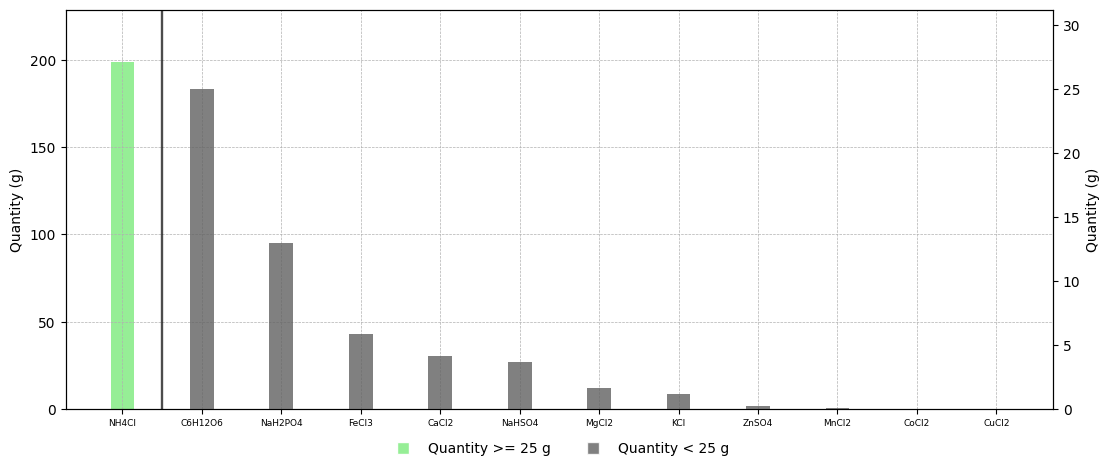

Exception in thread Thread-62:
Traceback (most recent call last):
  File "c:\Users\harou\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1052, in _bootstrap_inner
    self.run()
  File "c:\Users\harou\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1410, in run
    self.function(*self.args, **self.kwargs)
  File "C:\Users\harou\AppData\Local\Temp\ipykernel_29336\2382771805.py", line 122, in displayOrUpdateQuantitiesTableAndBarPlot
  File "C:\Users\harou\AppData\Local\Temp\ipykernel_29336\16332298.py", line 22, in createdOrUpdateTableOfResults
AttributeError: 'NoneType' object has no attribute 'children'


In [53]:
displayResultsInterface()

In [57]:
df_results

,compound name,formula,formula without water,number of water,compound mass [g],C,H,O,N,S,P,Cl,Na,K,Mg,Ca,Fe,Mn,Zn,Cu,Co,Mo,Ni,Br,MW [g/mol],C [g/g],C mass [g],H [g/g],H mass [g],O [g/g],O mass [g],N [g/g],N mass [g],S [g/g],S mass [g],P [g/g],P mass [g],Cl [g/g],Cl mass [g],Na [g/g],Na mass [g],K [g/g],K mass [g],Mg [g/g],Mg mass [g],Ca [g/g],Ca mass [g],Fe [g/g],Fe mass [g],Mn [g/g],Mn mass [g],Zn [g/g],Zn mass [g],Cu [g/g],Cu mass [g],Co [g/g],Co mass [g],Mo [g/g],Mo mass [g],Ni [g/g],Ni mass [g],Br [g/g],Br mass [g]
0,Ammonium chloride,NH4Cl,NH4Cl,0,198.992,0,4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,53.489,0.000,0.000,0.075,15.000,0.000,0.000,0.262,52.109,0.000,0.000,0.000,0.000,0.663,131.882,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,Calcium chloride,CaCl2·2H2O,CaCl2,2,4.147,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,110.978,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.639,2.649,0.000,0.000,0.000,0.000,0.000,0.000,0.361,1.498,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,Cobalt chloride,CoCl2·6H2O,CoCl2,6,0.009,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,129.833,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.546,0.005,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.454,0.004,0.000,0.000,0.000,0.000,0.000,0.000
3,Copper chloride dihydrate,CuCl2·2H2O,CuCl2,2,0.009,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,134.446,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.527,0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.473,0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,Ferric chloride hexahydrate,FeCl3·6H2O,FeCl3,6,5.878,0,0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,162.195,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.656,3.854,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.344,2.024,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,Glucose,C6H12O6,C6H12O6,0,24.999,6,12,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,180.156,0.400,10.000,0.067,1.678,0.533,13.320,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,Magnesium chloride hexahydrate,MgCl2·6H2O,MgCl2,6,1.641,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,95.205,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.745,1.222,0.000,0.000,0.000,0.000,0.255,0.419,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,Manganese chloride,MnCl2·4H2O,MnCl2,4,0.101,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,125.838,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.563,0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.437,0.044,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,Monosodium dihydrogen phosphate,NaH2PO4,NaH2PO4,0,12.978,0,2,4,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,119.976,0.000,0.000,0.017,0.218,0.533,6.923,0.000,0.000,0.000,0.000,0.258,3.350,0.000,0.000,0.192,2.487,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,Potassium chloride,KCl,KCl,0,1.163,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,74.548,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.476,0.553,0.000,0.000,0.524,0.610,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [56]:
comparasion_df

,Element,Reference elemental growth yield [gCDW/g],Excess Factor,Reference element mass [g/L],Required element mass [g/L],Obtained element mass [g/L]
0,C,1.000,1.000,10.000,10.000,10.000
1,N,8.000,3.000,1.250,3.750,52.109
2,S,100.000,5.000,0.100,0.500,1.023
3,P,33.000,5.000,0.303,1.515,3.350
4,K,100.000,5.000,0.100,0.500,0.610
5,Mg,200.000,5.000,0.050,0.250,0.419
6,Ca,100.000,10.000,0.100,1.000,1.498
7,Fe,200.000,10.000,0.050,0.500,2.024
8,Mn,10000.000,20.000,0.001,0.020,0.044
9,Zn,10000.000,20.000,0.001,0.020,0.096


In [ ]:
# plotObtainedElementalGrowthYield()